<a href="https://colab.research.google.com/github/sergioGarcia91/BucaramangaSeismicNest_ML/blob/main/ML_SismosNido_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- These models will consider the entire catalog under a criterion very similar to the Gutenberg-Richter Law. To do this, the number of events $Ml\geq$ at $2.5, 3.0, 3.5, 4.0, 4.5., 5.0, 5.5$ and $6.0$ that have occurred to date will be calculated for each day vector. Then each Ml subgroup will be divided by the total number of events recorded in the catalog to date, to have normalized between 0 and 1.
- The catalog of events with depths greater than 100 km and $Ml\geq 2.5$ will continue to be used.

# Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Para evaluar el modelo
from sklearn.neural_network import MLPClassifier # Para la Red Neuronal
from joblib import dump, load # guardar el modelo
from datetime import datetime, timedelta

# Load Data

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV3/'


In [ ]:
# The catalog of events of more than 100 km is loaded
df_Filtrado_100km = pd.read_csv(pathDatos+'df_100km.csv')
df_Filtrado_100km['Date-Time'] = pd.to_datetime(df_Filtrado_100km['Date-Time'], yearfirst=True)
df_Filtrado_100km.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148125 entries, 0 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148125 non-null  object        
 1   HORA_UTC                148125 non-null  object        
 2   LATITUD (grados)        148125 non-null  float64       
 3   LONGITUD (grados)       148125 non-null  float64       
 4   PROFUNDIDAD (Km)        148125 non-null  float64       
 5   MAGNITUD Ml             148125 non-null  float64       
 6   ERROR LATITUD (Km)      148125 non-null  float64       
 7   ERROR LONGITUD (Km)     148125 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148125 non-null  float64       
 9   Date-Time               148125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.3+ MB


In [ ]:
df_Filtrado_100km.head()

FECHA  HORA_UTC  LATITUD (grados)  LONGITUD (grados)  \
0  1994-01-01  00:06:37             6.839            -72.950   
1  1994-01-01  08:17:30             6.877            -72.912   
2  1994-01-02  01:55:17             6.806            -72.898   
3  1994-01-02  04:49:35             6.898            -73.095   
4  1994-01-02  05:55:47             6.736            -73.201   

   PROFUNDIDAD (Km)  MAGNITUD Ml  ERROR LATITUD (Km)  ERROR LONGITUD (Km)  \
0             158.6          3.7                15.8                 17.2   
1             166.6          4.1                14.7                 19.9   
2             150.0          3.0                12.8                 15.8   
3             150.0          3.1                 8.3                  8.7   
4             150.0          5.3                17.1                 18.0   

   ERROR PROFUNDIDAD (Km)           Date-Time  
0                    19.5 1994-01-01 00:06:37  
1                    16.2 1994-01-01 08:17:30  
2                    17.8 1994-01-02 01:55:17  
3                    11.3 1994-01-02 04:49:35  
4                    24.7 1994-01-02 05:55:47

In [ ]:
df_Filtrado_100km.describe()

LATITUD (grados)  LONGITUD (grados)  PROFUNDIDAD (Km)    MAGNITUD Ml  \
count     148125.000000      148125.000000     148125.000000  148125.000000   
mean           6.798031         -73.130428        143.920276       2.055534   
std            0.052092           0.080273          7.807388       0.616441   
min            6.500000         -73.400000        100.000000       0.100000   
25%            6.772000         -73.173000        140.080000       1.600000   
50%            6.799000         -73.143000        144.650000       1.900000   
75%            6.824000         -73.096000        148.500000       2.400000   
max            7.100000         -72.800000        436.500000       6.300000   

       ERROR LATITUD (Km)  ERROR LONGITUD (Km)  ERROR PROFUNDIDAD (Km)  
count       148125.000000        148125.000000           148125.000000  
mean             4.629923             6.881422                7.071674  
std              3.206937             6.132504                4.887473  
min              0.000000             0.000000                0.000000  
25%              2.616000             3.100000                4.200000  
50%              4.100000             5.190000                6.500000  
75%              5.800000             8.700000                8.850000  
max             99.900000            99.900000               99.900000

## Filter Ml 2.5

In [ ]:
df_Filtrado_100km_ml25 = df_Filtrado_100km[df_Filtrado_100km['MAGNITUD Ml'] >= 2.5].copy()
df_Filtrado_100km_ml25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31899 entries, 0 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   FECHA                   31899 non-null  object        
 1   HORA_UTC                31899 non-null  object        
 2   LATITUD (grados)        31899 non-null  float64       
 3   LONGITUD (grados)       31899 non-null  float64       
 4   PROFUNDIDAD (Km)        31899 non-null  float64       
 5   MAGNITUD Ml             31899 non-null  float64       
 6   ERROR LATITUD (Km)      31899 non-null  float64       
 7   ERROR LONGITUD (Km)     31899 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  31899 non-null  float64       
 9   Date-Time               31899 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 2.7+ MB


# DF por día nuevo / Ley Gutenberg-Richter

In [ ]:
dict_Dias = {'Dia':[],
             '2.5':[],
             '3.0':[],
             '3.5':[],
             '4.0':[],
             '4.5':[],
             '5.0':[],
             '5.5':[],
             '6.0':[],
             'Y': []}

# Se va iniciar desde el mes de febrero de 1994
inicio = np.datetime64('1994-02-01')
fin = (np.datetime64('2024-03-01') - 7) # para predecir en los 7 días siguientes
array_fechas = np.arange(inicio, fin, dtype='datetime64[D]')

for date in array_fechas:
  print(date)
  filtroFecha = df_Filtrado_100km_ml25['FECHA'] <= str(date)
  df_filtrado = df_Filtrado_100km_ml25[filtroFecha]
  totalEventos = sum(filtroFecha)

  dict_Dias['Dia'].append(str(date))

  for ml in np.arange(2.5, 6.5, 0.5):
    nE = df_filtrado['MAGNITUD Ml'] >= ml
    porcentajeEventos = sum(nE) / totalEventos
    dict_Dias[str(ml)].append(porcentajeEventos)

  filtroY = (df_Filtrado_100km_ml25['FECHA'] >= str(date +1 )) & (df_Filtrado_100km_ml25['FECHA'] <= str(date + 7 ))
  dfMl = df_Filtrado_100km_ml25[filtroY].copy()
  nMl45 = sum(dfMl['MAGNITUD Ml'] >= 4.5)
  print(nMl45)
  if nMl45 >= 1:
    dict_Dias['Y'].append(1)
  else:
    dict_Dias['Y'].append(0)


df_Dias = pd.DataFrame.from_dict(dict_Dias)
df_Dias

Se truncaron las últimas líneas 5000 del resultado de transmisión.
2017-04-20
0
2017-04-21
0
2017-04-22
0
2017-04-23
0
2017-04-24
0
2017-04-25
0
2017-04-26
0
2017-04-27
0
2017-04-28
0
2017-04-29
0
2017-04-30
0
2017-05-01
0
2017-05-02
0
2017-05-03
0
2017-05-04
0
2017-05-05
0
2017-05-06
0
2017-05-07
0
2017-05-08
0
2017-05-09
0
2017-05-10
0
2017-05-11
0
2017-05-12
0
2017-05-13
0
2017-05-14
0
2017-05-15
0
2017-05-16
0
2017-05-17
0
2017-05-18
0
2017-05-19
0
2017-05-20
1
2017-05-21
1
2017-05-22
1
2017-05-23
1
2017-05-24
1
2017-05-25
1
2017-05-26
1
2017-05-27
0
2017-05-28
0
2017-05-29
0
2017-05-30
0
2017-05-31
0
2017-06-01
0
2017-06-02
0
2017-06-03
0
2017-06-04
0
2017-06-05
0
2017-06-06
0
2017-06-07
0
2017-06-08
0
2017-06-09
0
2017-06-10
0
2017-06-11
0
2017-06-12
0
2017-06-13
0
2017-06-14
0
2017-06-15
0
2017-06-16
0
2017-06-17
0
2017-06-18
0
2017-06-19
0
2017-06-20
0
2017-06-21
0
2017-06-22
0
2017-06-23
0
2017-06-24
0
2017-06-25
0
2017-06-26
0
2017-06-27
0
2017-06-28
0
2017-06-29
0
2017-06-30

Dia  2.5       3.0       3.5       4.0       4.5       5.0  \
0      1994-02-01  1.0  0.812950  0.410072  0.093525  0.028777  0.007194   
1      1994-02-02  1.0  0.821918  0.417808  0.102740  0.027397  0.006849   
2      1994-02-03  1.0  0.821192  0.417219  0.099338  0.026490  0.006623   
3      1994-02-04  1.0  0.824675  0.422078  0.097403  0.025974  0.006494   
4      1994-02-05  1.0  0.811321  0.415094  0.094340  0.025157  0.006289   
...           ...  ...       ...       ...       ...       ...       ...   
10974  2024-02-18  1.0  0.426137  0.158491  0.053667  0.015661  0.004614   
10975  2024-02-19  1.0  0.426173  0.158481  0.053664  0.015660  0.004613   
10976  2024-02-20  1.0  0.426182  0.158524  0.053720  0.015689  0.004613   
10977  2024-02-21  1.0  0.426187  0.158514  0.053717  0.015688  0.004612   
10978  2024-02-22  1.0  0.426196  0.158557  0.053741  0.015718  0.004612   

            5.5      6.0  Y  
0      0.000000  0.00000  0  
1      0.000000  0.00000  0  
2      0.000000  0.00000  0  
3      0.000000  0.00000  0  
4      0.000000  0.00000  0  
...         ...      ... ..  
10974  0.001255  0.00022  1  
10975  0.001255  0.00022  1  
10976  0.001255  0.00022  1  
10977  0.001255  0.00022  1  
10978  0.001255  0.00022  0  

[10979 rows x 10 columns]

For the magnitude of 2.5 it will always give $1.0$ because only events of this magnitude or greater are being considered, so when evaluating with 2.5 all events are, therefore it gives $1.0$.

## Save/Load DF LGR

In [ ]:
df_Dias.to_csv(pathDatos+'df_Dias_LGR_v3.csv', index=False)

In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_LGR_v3.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
df_Dias

Dia  2.5       3.0       3.5       4.0       4.5       5.0  \
0      1994-02-01  1.0  0.812950  0.410072  0.093525  0.028777  0.007194   
1      1994-02-02  1.0  0.821918  0.417808  0.102740  0.027397  0.006849   
2      1994-02-03  1.0  0.821192  0.417219  0.099338  0.026490  0.006623   
3      1994-02-04  1.0  0.824675  0.422078  0.097403  0.025974  0.006494   
4      1994-02-05  1.0  0.811321  0.415094  0.094340  0.025157  0.006289   
...           ...  ...       ...       ...       ...       ...       ...   
10974  2024-02-18  1.0  0.426137  0.158491  0.053667  0.015661  0.004614   
10975  2024-02-19  1.0  0.426173  0.158481  0.053664  0.015660  0.004613   
10976  2024-02-20  1.0  0.426182  0.158524  0.053720  0.015689  0.004613   
10977  2024-02-21  1.0  0.426187  0.158514  0.053717  0.015688  0.004612   
10978  2024-02-22  1.0  0.426196  0.158557  0.053741  0.015718  0.004612   

            5.5      6.0  Y      Fecha  
0      0.000000  0.00000  0 1994-02-01  
1      0.000000  0.00000  0 1994-02-02  
2      0.000000  0.00000  0 1994-02-03  
3      0.000000  0.00000  0 1994-02-04  
4      0.000000  0.00000  0 1994-02-05  
...         ...      ... ..        ...  
10974  0.001255  0.00022  1 2024-02-18  
10975  0.001255  0.00022  1 2024-02-19  
10976  0.001255  0.00022  1 2024-02-20  
10977  0.001255  0.00022  1 2024-02-21  
10978  0.001255  0.00022  0 2024-02-22  

[10979 rows x 11 columns]

### Create and/X

In [ ]:
df_Dias.columns

Index(['Dia', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0', 'Y',
       'Fecha'],
      dtype='object')

In [ ]:
# Entrenamiento >2022
filtro2022 = (df_Dias['Fecha'].dt.year < 2022).to_numpy()
# Test >=2022
filtro2023 = (df_Dias['Fecha'].dt.year >= 2022).to_numpy()

y2021 = df_Dias['Y'][filtro2022].to_numpy()
X2021 = df_Dias[['2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0']][filtro2022].to_numpy()

y2022 = df_Dias['Y'][filtro2023].to_numpy()
X2022 = df_Dias[['2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0']][filtro2023].to_numpy()

In [ ]:
y2021.shape

(10196,)

In [ ]:
X2021.shape

(10196, 8)

## Save them

In [ ]:
prefijo = pathDatos + 'Todos_LGR_'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)


/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/Todos_LGR_


# DF for new day / Gutenberg-Richter Law v2

It will be considered again for Ml values ​​bounded every 0.5.

In [ ]:
dict_Dias = {'Dia':[],
             '2.5':[],
             '3.0':[],
             '3.5':[],
             '4.0':[],
             '4.5':[],
             '5.0':[],
             '5.5':[],
             '6.0':[],
             'Y': []}

# Se va iniciar desde el mes de febrero de 1994
inicio = np.datetime64('1994-02-01')
fin = (np.datetime64('2024-03-01') - 7) # para predecir en los 7 días siguientes
array_fechas = np.arange(inicio, fin, dtype='datetime64[D]')

for date in array_fechas:
  print(date)
  filtroFecha = df_Filtrado_100km_ml25['FECHA'] <= str(date)
  df_filtrado = df_Filtrado_100km_ml25[filtroFecha]
  totalEventos = sum(filtroFecha)

  dict_Dias['Dia'].append(str(date))

  for ml in np.arange(2.5, 6.5, 0.5):
    nE = (df_filtrado['MAGNITUD Ml'] >= ml) & (df_filtrado['MAGNITUD Ml'] < (ml+0.5) )
    porcentajeEventos = sum(nE) / totalEventos
    dict_Dias[str(ml)].append(porcentajeEventos)

  filtroY = (df_Filtrado_100km_ml25['FECHA'] >= str(date +1 )) & (df_Filtrado_100km_ml25['FECHA'] <= str(date + 7 ))
  dfMl = df_Filtrado_100km_ml25[filtroY].copy()
  nMl45 = sum(dfMl['MAGNITUD Ml'] >= 4.5)
  print(nMl45)
  if nMl45 >= 1:
    dict_Dias['Y'].append(1)
  else:
    dict_Dias['Y'].append(0)


df_Dias = pd.DataFrame.from_dict(dict_Dias)
df_Dias

Se truncaron las últimas líneas 5000 del resultado de transmisión.
2017-04-20
0
2017-04-21
0
2017-04-22
0
2017-04-23
0
2017-04-24
0
2017-04-25
0
2017-04-26
0
2017-04-27
0
2017-04-28
0
2017-04-29
0
2017-04-30
0
2017-05-01
0
2017-05-02
0
2017-05-03
0
2017-05-04
0
2017-05-05
0
2017-05-06
0
2017-05-07
0
2017-05-08
0
2017-05-09
0
2017-05-10
0
2017-05-11
0
2017-05-12
0
2017-05-13
0
2017-05-14
0
2017-05-15
0
2017-05-16
0
2017-05-17
0
2017-05-18
0
2017-05-19
0
2017-05-20
1
2017-05-21
1
2017-05-22
1
2017-05-23
1
2017-05-24
1
2017-05-25
1
2017-05-26
1
2017-05-27
0
2017-05-28
0
2017-05-29
0
2017-05-30
0
2017-05-31
0
2017-06-01
0
2017-06-02
0
2017-06-03
0
2017-06-04
0
2017-06-05
0
2017-06-06
0
2017-06-07
0
2017-06-08
0
2017-06-09
0
2017-06-10
0
2017-06-11
0
2017-06-12
0
2017-06-13
0
2017-06-14
0
2017-06-15
0
2017-06-16
0
2017-06-17
0
2017-06-18
0
2017-06-19
0
2017-06-20
0
2017-06-21
0
2017-06-22
0
2017-06-23
0
2017-06-24
0
2017-06-25
0
2017-06-26
0
2017-06-27
0
2017-06-28
0
2017-06-29
0
2017-06-30

Dia       2.5       3.0       3.5       4.0       4.5       5.0  \
0      1994-02-01  0.187050  0.402878  0.316547  0.064748  0.021583  0.007194   
1      1994-02-02  0.178082  0.404110  0.315068  0.075342  0.020548  0.006849   
2      1994-02-03  0.178808  0.403974  0.317881  0.072848  0.019868  0.006623   
3      1994-02-04  0.175325  0.402597  0.324675  0.071429  0.019481  0.006494   
4      1994-02-05  0.188679  0.396226  0.320755  0.069182  0.018868  0.006289   
...           ...       ...       ...       ...       ...       ...       ...   
10974  2024-02-18  0.573863  0.267646  0.104824  0.038006  0.011047  0.003358   
10975  2024-02-19  0.573827  0.267692  0.104817  0.038004  0.011047  0.003358   
10976  2024-02-20  0.573818  0.267658  0.104804  0.038031  0.011077  0.003357   
10977  2024-02-21  0.573813  0.267673  0.104797  0.038028  0.011076  0.003357   
10978  2024-02-22  0.573804  0.267639  0.104816  0.038024  0.011106  0.003357   

            5.5      6.0  Y  
0      0.000000  0.00000  0  
1      0.000000  0.00000  0  
2      0.000000  0.00000  0  
3      0.000000  0.00000  0  
4      0.000000  0.00000  0  
...         ...      ... ..  
10974  0.001036  0.00022  1  
10975  0.001036  0.00022  1  
10976  0.001035  0.00022  1  
10977  0.001035  0.00022  1  
10978  0.001035  0.00022  0  

[10979 rows x 10 columns]

## Save/Load DF LGR

In [ ]:
df_Dias.to_csv(pathDatos+'df_Dias_LGR2_v3.csv', index=False)

In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_LGR2_v3.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
df_Dias

Dia       2.5       3.0       3.5       4.0       4.5       5.0  \
0      1994-02-01  0.187050  0.402878  0.316547  0.064748  0.021583  0.007194   
1      1994-02-02  0.178082  0.404110  0.315068  0.075342  0.020548  0.006849   
2      1994-02-03  0.178808  0.403974  0.317881  0.072848  0.019868  0.006623   
3      1994-02-04  0.175325  0.402597  0.324675  0.071429  0.019481  0.006494   
4      1994-02-05  0.188679  0.396226  0.320755  0.069182  0.018868  0.006289   
...           ...       ...       ...       ...       ...       ...       ...   
10974  2024-02-18  0.573863  0.267646  0.104824  0.038006  0.011047  0.003358   
10975  2024-02-19  0.573827  0.267692  0.104817  0.038004  0.011047  0.003358   
10976  2024-02-20  0.573818  0.267658  0.104804  0.038031  0.011077  0.003357   
10977  2024-02-21  0.573813  0.267673  0.104797  0.038028  0.011076  0.003357   
10978  2024-02-22  0.573804  0.267639  0.104816  0.038024  0.011106  0.003357   

            5.5      6.0  Y      Fecha  
0      0.000000  0.00000  0 1994-02-01  
1      0.000000  0.00000  0 1994-02-02  
2      0.000000  0.00000  0 1994-02-03  
3      0.000000  0.00000  0 1994-02-04  
4      0.000000  0.00000  0 1994-02-05  
...         ...      ... ..        ...  
10974  0.001036  0.00022  1 2024-02-18  
10975  0.001036  0.00022  1 2024-02-19  
10976  0.001035  0.00022  1 2024-02-20  
10977  0.001035  0.00022  1 2024-02-21  
10978  0.001035  0.00022  0 2024-02-22  

[10979 rows x 11 columns]

### Create and/X

In [ ]:
# Entrenamiento >2022
filtro2022 = (df_Dias['Fecha'].dt.year < 2022).to_numpy()
# Test >=2022
filtro2023 = (df_Dias['Fecha'].dt.year >= 2022).to_numpy()

y2021 = df_Dias['Y'][filtro2022].to_numpy()
X2021 = df_Dias[['2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0']][filtro2022].to_numpy()

y2022 = df_Dias['Y'][filtro2023].to_numpy()
X2022 = df_Dias[['2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0']][filtro2023].to_numpy()

## Save them

In [ ]:
prefijo = pathDatos + 'Todos_LGR2_'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/Todos_LGR2_


# Training

In [ ]:
# Se cargan los archivos V1
X2022 = np.loadtxt(pathDatos+'Todos_LGR__X2022.txt')
y2022 = np.loadtxt(pathDatos+'Todos_LGR__y2022.txt')
X2021 = np.loadtxt(pathDatos+'Todos_LGR__X2021.txt')
y2021 = np.loadtxt(pathDatos+'Todos_LGR__y2021.txt')

In [ ]:
# Se cargan los archivos V2
X2022 = np.loadtxt(pathDatos+'Todos_LGR2__X2022.txt')
y2022 = np.loadtxt(pathDatos+'Todos_LGR2__y2022.txt')
X2021 = np.loadtxt(pathDatos+'Todos_LGR2__X2021.txt')
y2021 = np.loadtxt(pathDatos+'Todos_LGR2__y2021.txt')

The layer criteria of the previous models (version 2) will be maintained, and simpler models will be included. The score is required to be higher than 0.9.

```python
[2000, 5]
[1500, 5]
[420, 5]
[210, 5] # this 5 times
[8, 8] # new
[5, 5] # new
[1, 1] # new
```

The Score is modified to 0.7 or higher, since the models do not exceed 0.73.

Even with 200 iterations, the score was not higher than 0.73.

In [ ]:
letras = 'LGR2'
pathSave = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v3/'

# Proposal of 7 structures considering the previous models
estuctura = [[2000, 5],
             [1500, 5],
             [420, 5],
             [210, 5],
             [8, 8],
             [5, 5],
             [1, 1]]

scoreInteres = 0.7
intentos = 5

for hl in estuctura:
  c = 0

  while c <= intentos:
    print('\n ', c)

    modelo_MLPClass = MLPClassifier(hidden_layer_sizes=tuple(hl),
                                  activation='relu', #identity, logistic, tanh, relu
                                  early_stopping=False, solver='adam', max_iter=30)#, random_state= 0)
    # Se entrena
    tinicio = time.perf_counter() # Segundos

    modelo_MLPClass.fit(X2021, y2021)

    tfinal = time.perf_counter() # Segundos
    tiempo = tfinal - tinicio

    print('Segundos empleados: ',tiempo)

    scoreMLPClass = modelo_MLPClass.score(X2021, y2021)
    print('Score: ', scoreMLPClass)


    #if scoreMLPClass >= scoreInteres:
    #  # guardar modelo
    #  Name = letras + f'_hl_{hl[0]}_{hl[1]}_int' + str(c) + '_scr' + str(round(scoreMLPClass, 3)) + '.joblib'
    #  dump(modelo_MLPClass, pathSave+Name)
    #  print(Name)
    #  break

    if c == intentos:
      print('Nada ...')
    c += 1


  0
Segundos empleados:  19.158861912999782
Score:  0.7361710474695959

  1
Segundos empleados:  31.60392470900024
Score:  0.7362691251471165

  2
Segundos empleados:  13.316087249999327
Score:  0.7362691251471165

  3
Segundos empleados:  12.34255372699954
Score:  0.7329344841114163

  4
Segundos empleados:  30.952584263000062
Score:  0.7362691251471165

  5
Segundos empleados:  47.629087749000064
Score:  0.7362691251471165
Nada ...

  0
Segundos empleados:  12.385924167999292
Score:  0.7362691251471165

  1
Segundos empleados:  22.049012959999345
Score:  0.7362691251471165

  2
Segundos empleados:  13.268596552000417
Score:  0.7362691251471165

  3
Segundos empleados:  22.329455498000243
Score:  0.7362691251471165

  4
Segundos empleados:  15.679403680000178
Score:  0.7362691251471165

  5
Segundos empleados:  20.32997056000022
Score:  0.7362691251471165
Nada ...

  0
Segundos empleados:  6.3736917729993365
Score:  0.7355825814044723

  1
Segundos empleados:  6.7146997210002155
Scor

# Model graphs

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV3/'

## Load Catalogs

In [ ]:
df = pd.read_csv(pathDatos+'df_Total_1994_2024.csv')
df['Date-Time'] = pd.to_datetime(df['Date-Time'], yearfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148986 entries, 0 to 148985
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148986 non-null  object        
 1   HORA_UTC                148986 non-null  object        
 2   LATITUD (grados)        148986 non-null  float64       
 3   LONGITUD (grados)       148986 non-null  float64       
 4   PROFUNDIDAD (Km)        148986 non-null  float64       
 5   MAGNITUD Ml             148986 non-null  float64       
 6   ERROR LATITUD (Km)      148910 non-null  float64       
 7   ERROR LONGITUD (Km)     148910 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148910 non-null  float64       
 9   Date-Time               148986 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.4+ MB


In [ ]:
#df_Dias = pd.read_csv(pathDatos+'df_Dias_LGR_v3.csv')
df_Dias = pd.read_csv(pathDatos+'df_Dias_LGR2_v3.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
df_Dias

Dia       2.5       3.0       3.5       4.0       4.5       5.0  \
0      1994-02-01  0.187050  0.402878  0.316547  0.064748  0.021583  0.007194   
1      1994-02-02  0.178082  0.404110  0.315068  0.075342  0.020548  0.006849   
2      1994-02-03  0.178808  0.403974  0.317881  0.072848  0.019868  0.006623   
3      1994-02-04  0.175325  0.402597  0.324675  0.071429  0.019481  0.006494   
4      1994-02-05  0.188679  0.396226  0.320755  0.069182  0.018868  0.006289   
...           ...       ...       ...       ...       ...       ...       ...   
10974  2024-02-18  0.573863  0.267646  0.104824  0.038006  0.011047  0.003358   
10975  2024-02-19  0.573827  0.267692  0.104817  0.038004  0.011047  0.003358   
10976  2024-02-20  0.573818  0.267658  0.104804  0.038031  0.011077  0.003357   
10977  2024-02-21  0.573813  0.267673  0.104797  0.038028  0.011076  0.003357   
10978  2024-02-22  0.573804  0.267639  0.104816  0.038024  0.011106  0.003357   

            5.5      6.0  Y      Fecha  
0      0.000000  0.00000  0 1994-02-01  
1      0.000000  0.00000  0 1994-02-02  
2      0.000000  0.00000  0 1994-02-03  
3      0.000000  0.00000  0 1994-02-04  
4      0.000000  0.00000  0 1994-02-05  
...         ...      ... ..        ...  
10974  0.001036  0.00022  1 2024-02-18  
10975  0.001036  0.00022  1 2024-02-19  
10976  0.001035  0.00022  1 2024-02-20  
10977  0.001035  0.00022  1 2024-02-21  
10978  0.001035  0.00022  0 2024-02-22  

[10979 rows x 11 columns]

## Load Models

In [ ]:
listaModelos = !ls /content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v3
listaModelos

['LGR2_hl_1_1_int0_scr0.736.joblib     LGR_hl_1_1_int0_scr0.736.joblib',
 'LGR2_hl_1500_5_int0_scr0.736.joblib  LGR_hl_1500_5_int0_scr0.736.joblib',
 'LGR2_hl_2000_5_int0_scr0.736.joblib  LGR_hl_2000_5_int0_scr0.736.joblib',
 'LGR2_hl_210_5_int0_scr0.736.joblib   LGR_hl_210_5_int0_scr0.736.joblib',
 'LGR2_hl_420_5_int0_scr0.733.joblib   LGR_hl_420_5_int0_scr0.736.joblib',
 'LGR2_hl_5_5_int0_scr0.736.joblib     LGR_hl_5_5_int0_scr0.736.joblib',
 'LGR2_hl_8_8_int0_scr0.736.joblib     LGR_hl_8_8_int0_scr0.736.joblib']

In [ ]:
import re
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v3/'
listaModelos = !ls /content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v3
listaTemp = []
for i in range(len(listaModelos)):
  if len(re.split(r' ', listaModelos[i])) == 1:
    a = re.split(r' ', listaModelos[i])
    listaTemp.append(a[0])
  else:
    a = re.split(r' ', listaModelos[i])
    listaTemp.append(a[0])
    listaTemp.append(a[1])
listaModelos = np.reshape(np.array(listaTemp), (1,-1))
del(listaTemp)
listaModelos = listaModelos[0]
listaModelos

array(['LGR2_hl_1_1_int0_scr0.736.joblib', '',
       'LGR2_hl_1500_5_int0_scr0.736.joblib', '',
       'LGR2_hl_2000_5_int0_scr0.736.joblib', '',
       'LGR2_hl_210_5_int0_scr0.736.joblib', '',
       'LGR2_hl_420_5_int0_scr0.733.joblib', '',
       'LGR2_hl_5_5_int0_scr0.736.joblib', '',
       'LGR2_hl_8_8_int0_scr0.736.joblib', ''], dtype='<U35')

In [ ]:
listaModelos = list(listaModelos)
del(listaModelos[1])
listaModelos

['LGR2_hl_1_1_int0_scr0.736.joblib',
 'LGR2_hl_1500_5_int0_scr0.736.joblib',
 'LGR_hl_1500_5_int0_scr0.736.joblib',
 'LGR2_hl_2000_5_int0_scr0.736.joblib',
 'LGR_hl_2000_5_int0_scr0.736.joblib',
 'LGR2_hl_210_5_int0_scr0.736.joblib',
 ' LGR_hl_210_5_int0_scr0.736.joblib',
 'LGR2_hl_420_5_int0_scr0.733.joblib',
 ' LGR_hl_420_5_int0_scr0.736.joblib',
 'LGR2_hl_5_5_int0_scr0.736.joblib',
 '',
 'LGR2_hl_8_8_int0_scr0.736.joblib',
 '']

In [ ]:
listaModelos = ['LGR2_hl_1_1_int0_scr0.736.joblib',
                'LGR_hl_1_1_int0_scr0.736.joblib',
                'LGR2_hl_1500_5_int0_scr0.736.joblib',
                'LGR_hl_1500_5_int0_scr0.736.joblib',
                'LGR2_hl_2000_5_int0_scr0.736.joblib',
                'LGR_hl_2000_5_int0_scr0.736.joblib',
                'LGR2_hl_210_5_int0_scr0.736.joblib',
                'LGR_hl_210_5_int0_scr0.736.joblib',
                'LGR2_hl_420_5_int0_scr0.733.joblib',
                'LGR_hl_420_5_int0_scr0.736.joblib',
                'LGR2_hl_5_5_int0_scr0.736.joblib',
                'LGR_hl_5_5_int0_scr0.736.joblib',
                'LGR2_hl_8_8_int0_scr0.736.joblib',
                'LGR_hl_8_8_int0_scr0.736.joblib']

In [ ]:
len(listaModelos)

14

## Graph

In [ ]:
for modelo in listaModelos:
  print(modelo)

LGR2_hl_1_1_int0_scr0.736.joblib
LGR_hl_1_1_int0_scr0.736.joblib
LGR2_hl_1500_5_int0_scr0.736.joblib
LGR_hl_1500_5_int0_scr0.736.joblib
LGR2_hl_2000_5_int0_scr0.736.joblib
LGR_hl_2000_5_int0_scr0.736.joblib
LGR2_hl_210_5_int0_scr0.736.joblib
LGR_hl_210_5_int0_scr0.736.joblib
LGR2_hl_420_5_int0_scr0.733.joblib
LGR_hl_420_5_int0_scr0.736.joblib
LGR2_hl_5_5_int0_scr0.736.joblib
LGR_hl_5_5_int0_scr0.736.joblib
LGR2_hl_8_8_int0_scr0.736.joblib
LGR_hl_8_8_int0_scr0.736.joblib


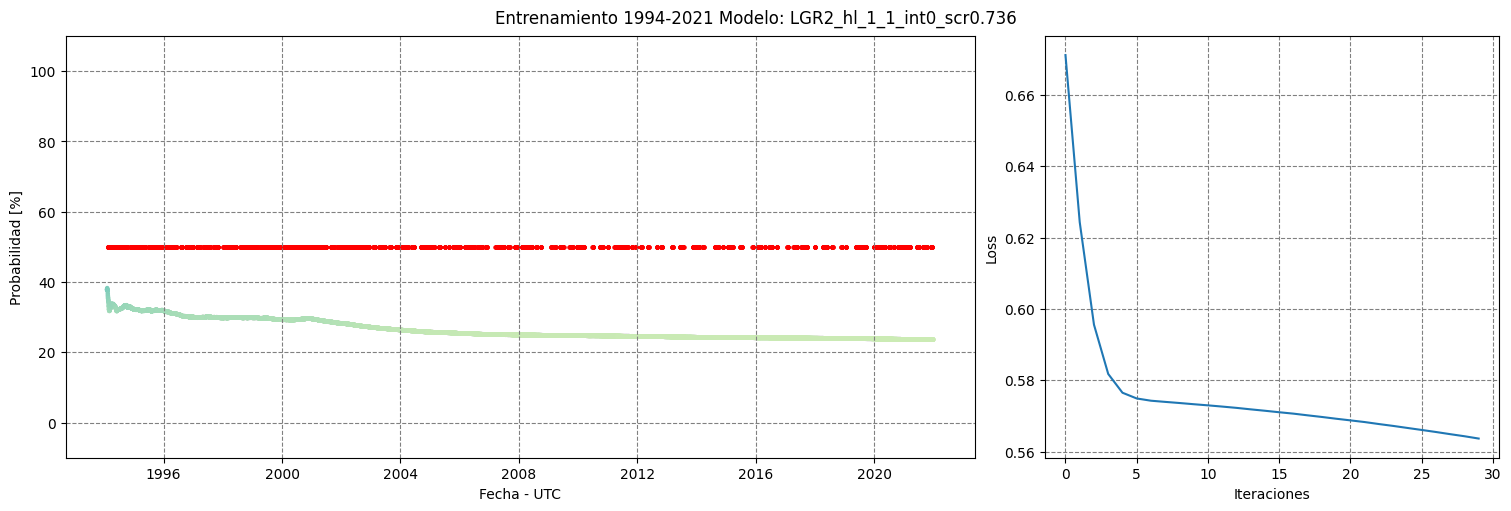

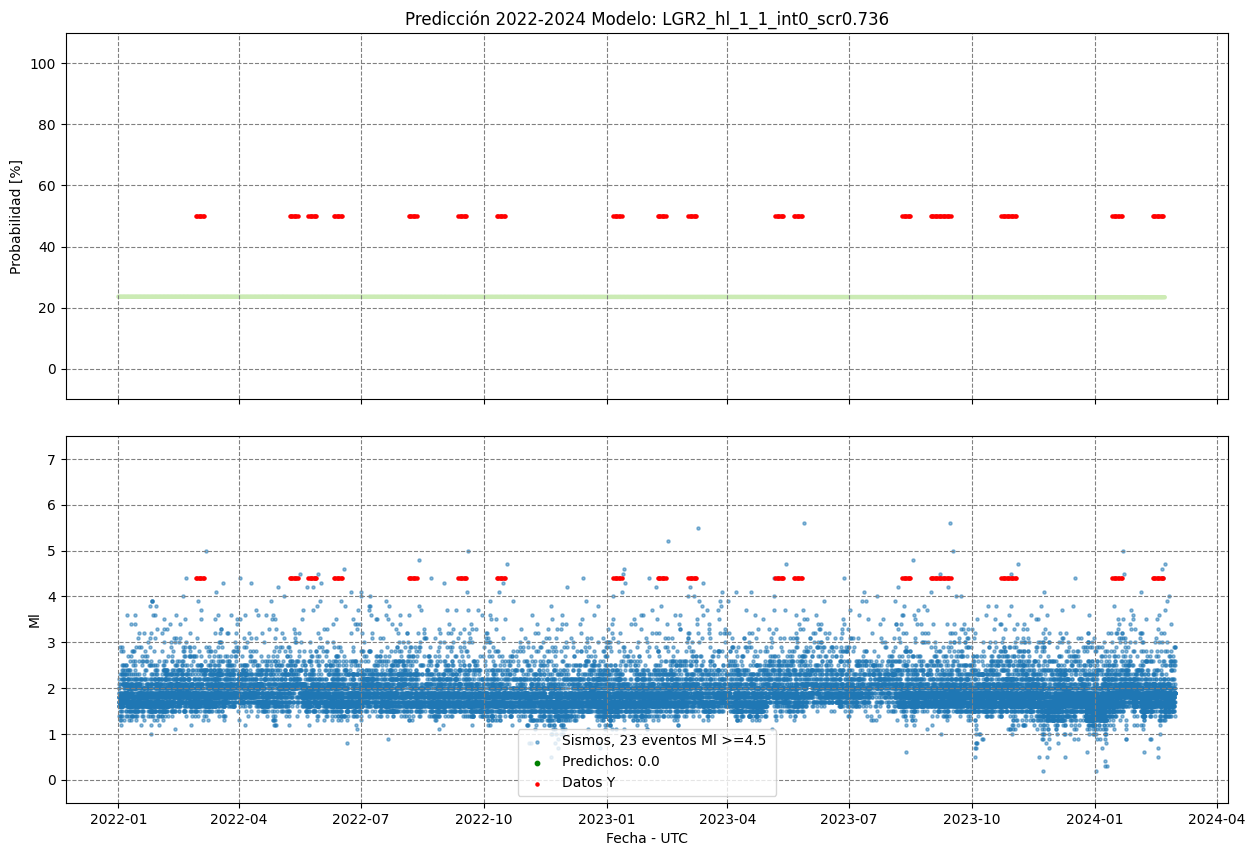

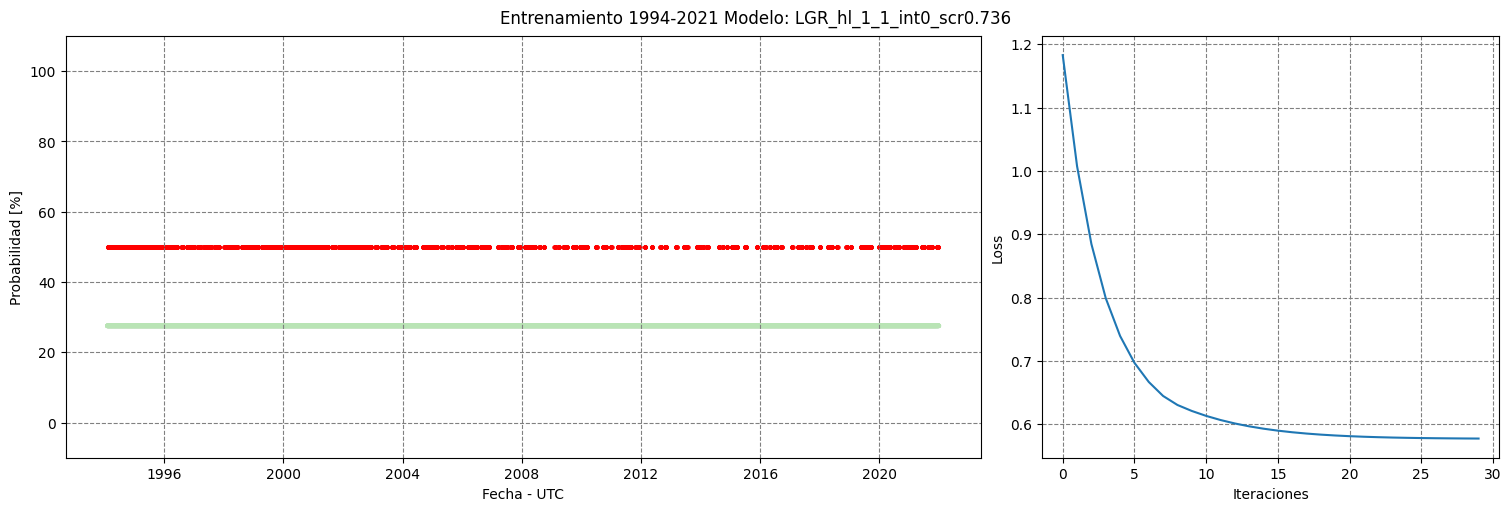

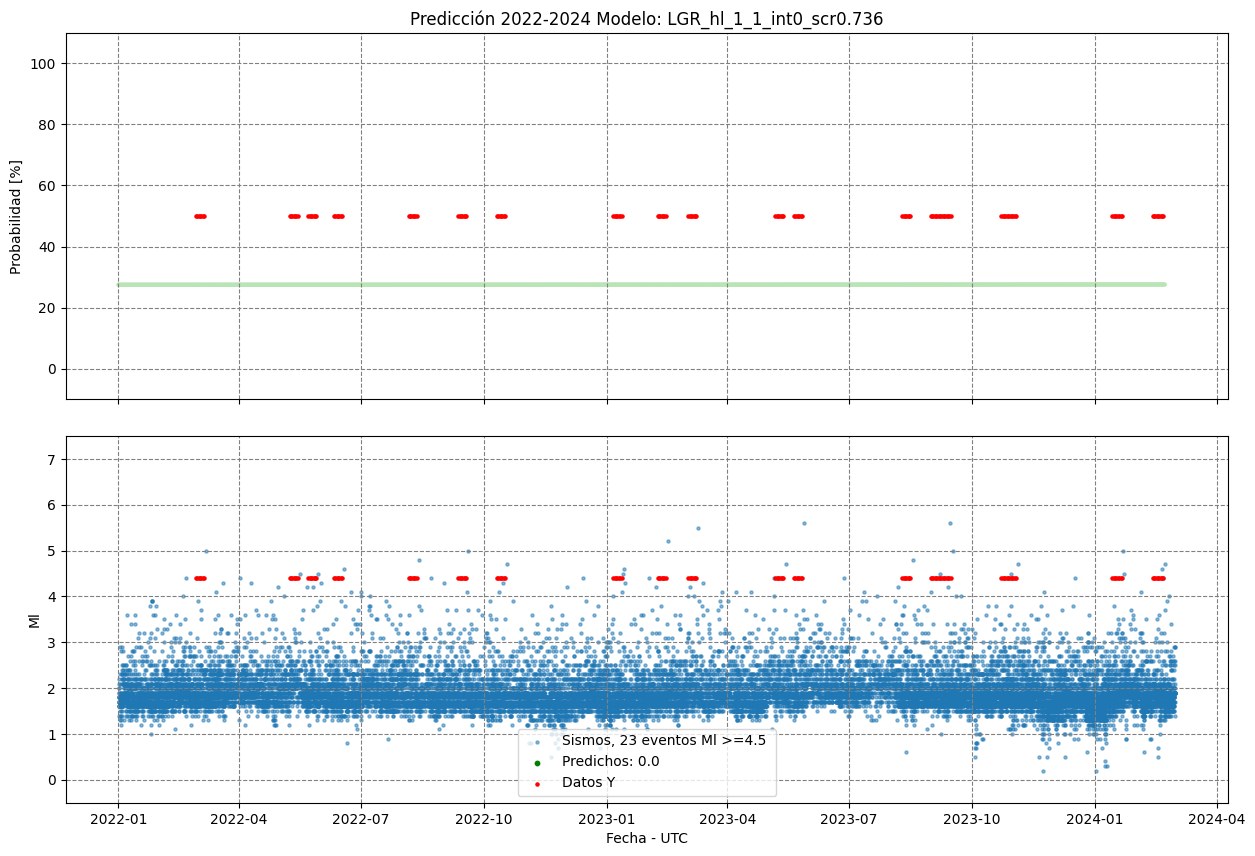

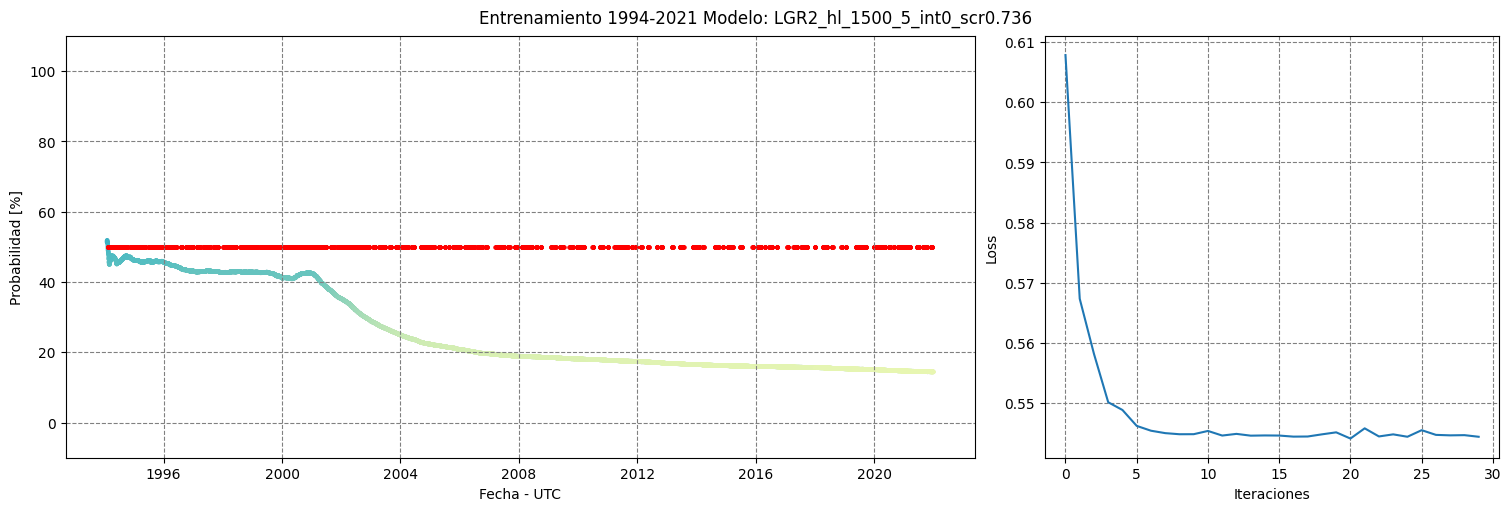

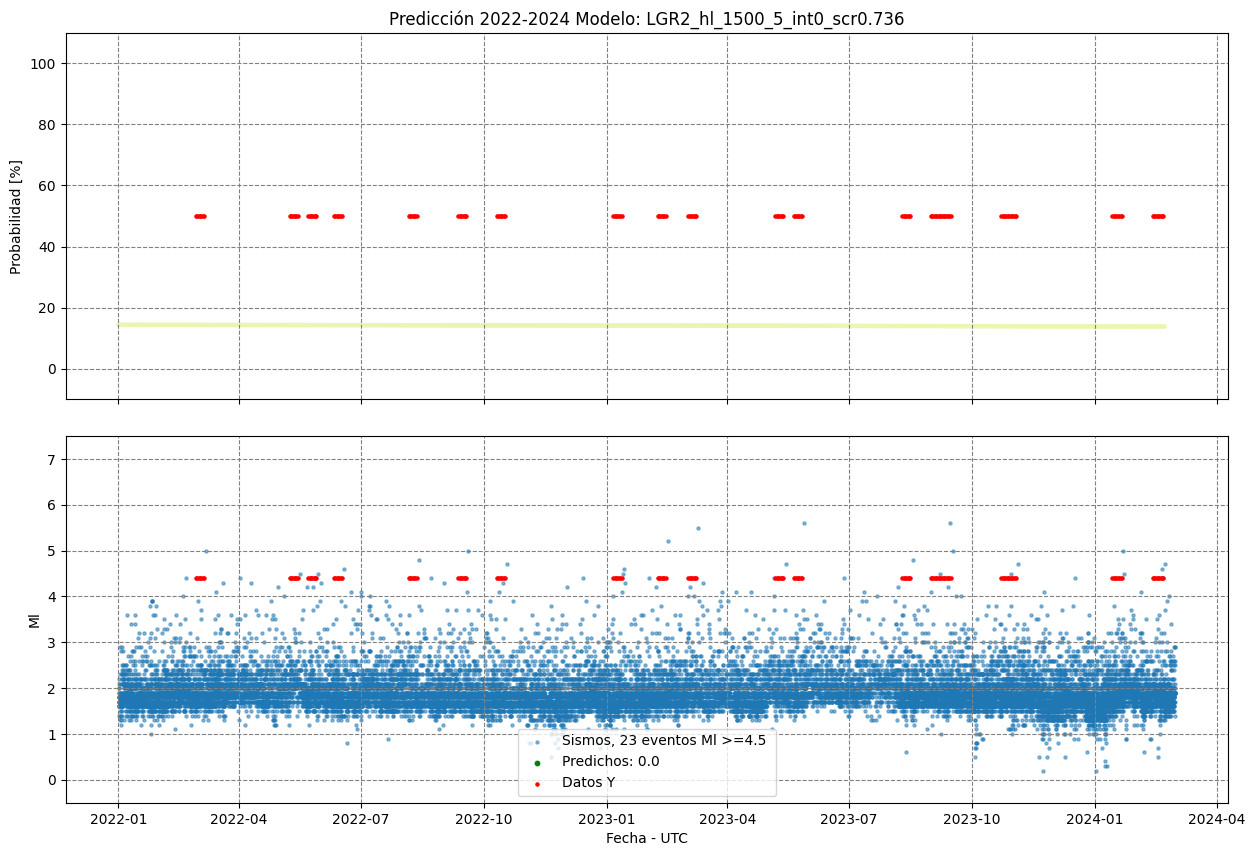

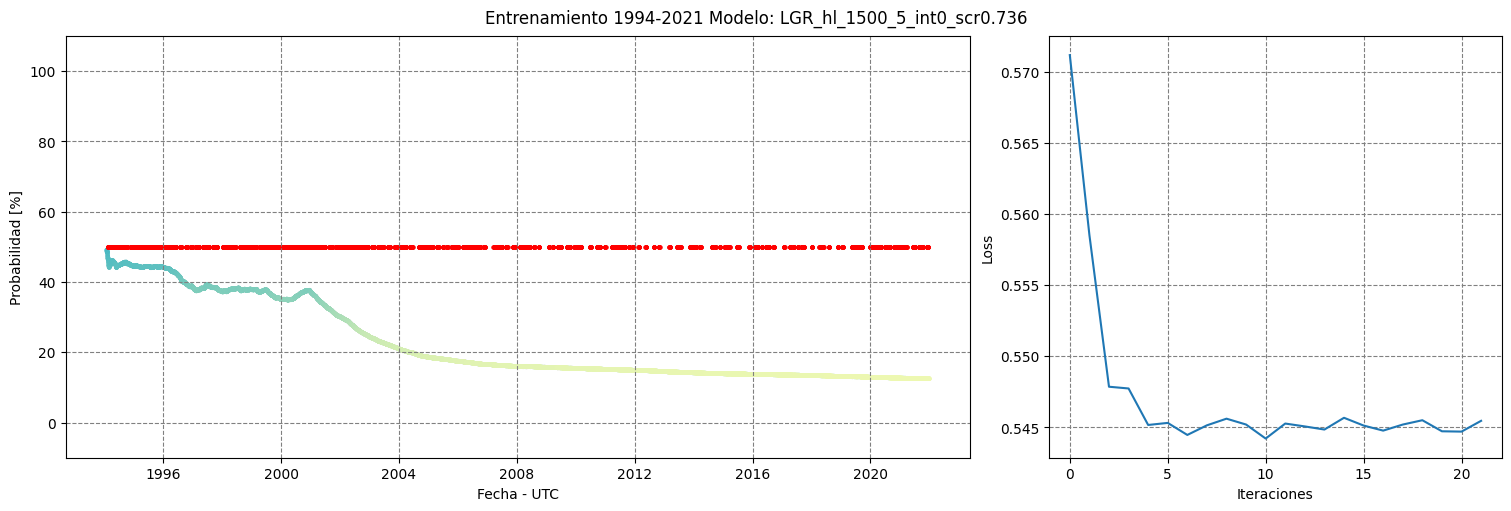

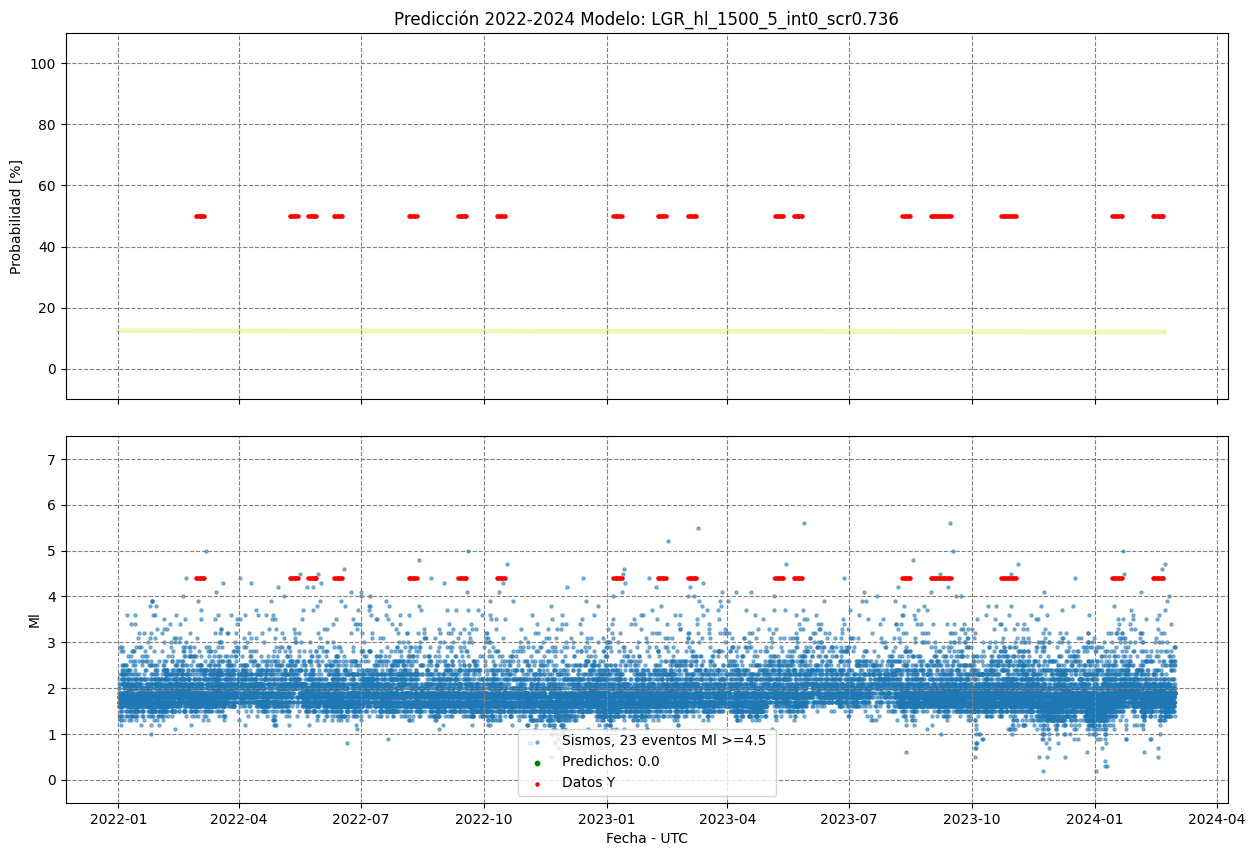

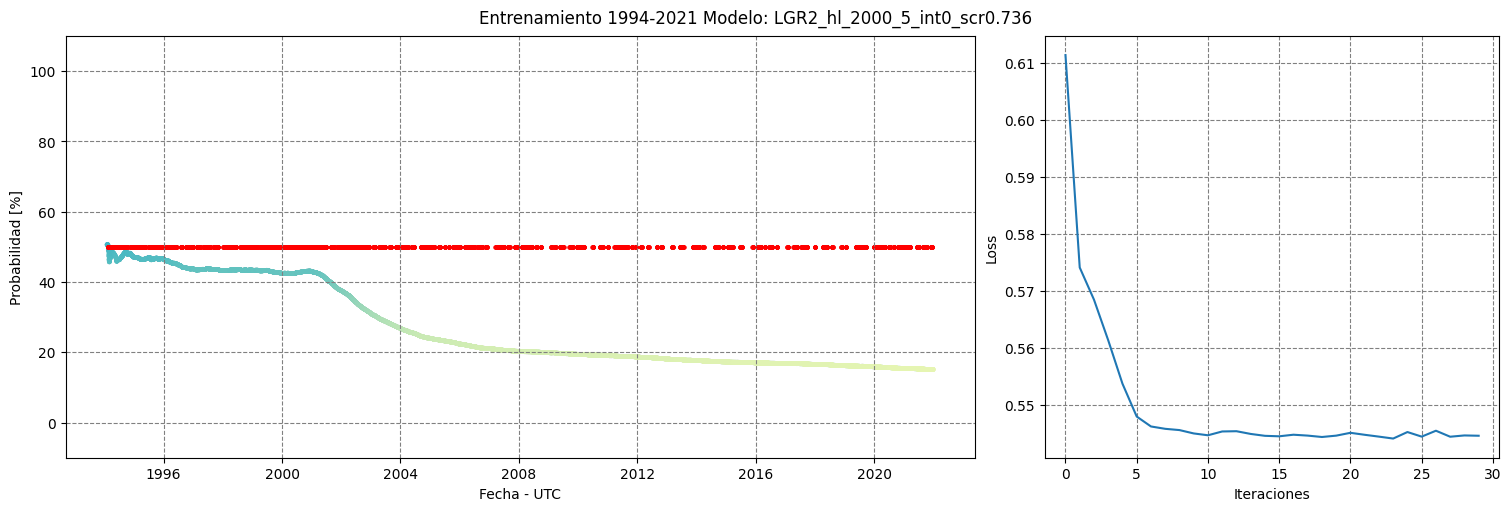

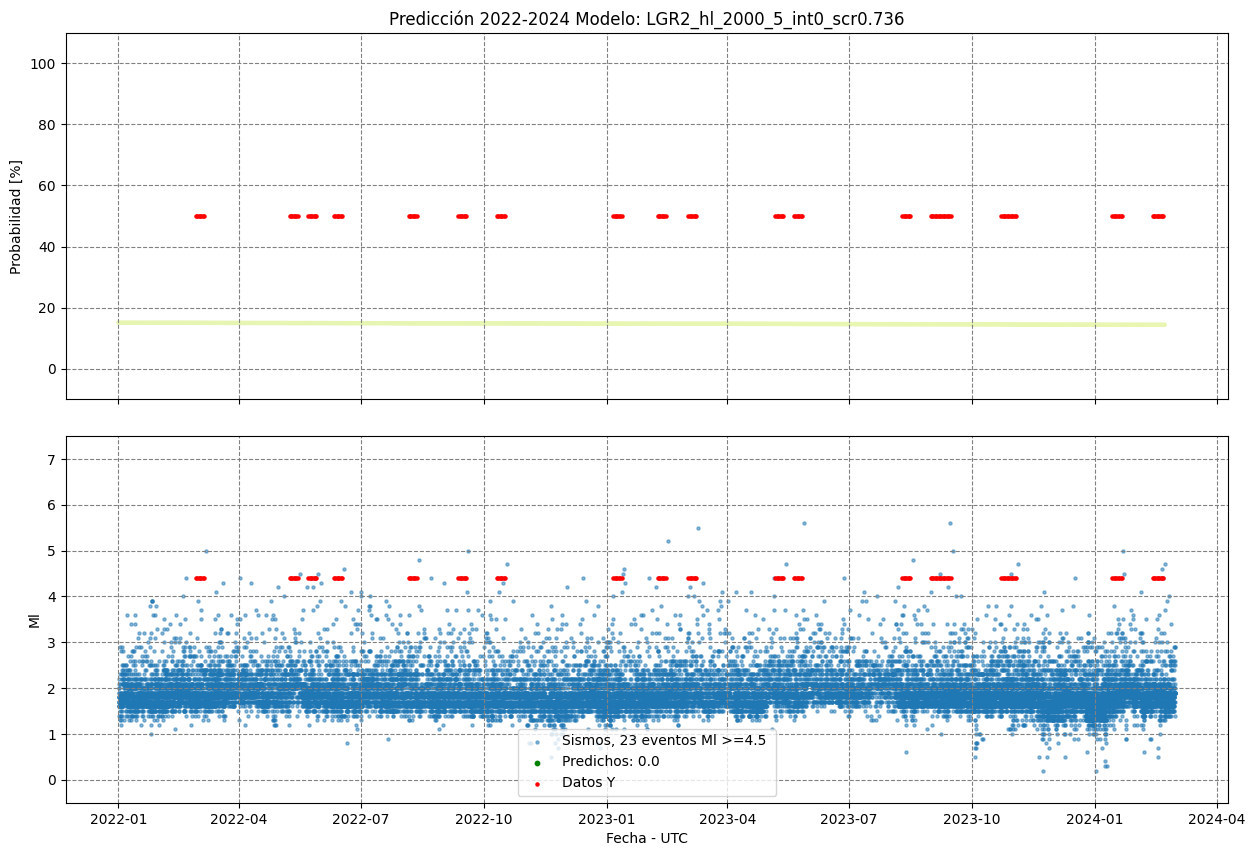

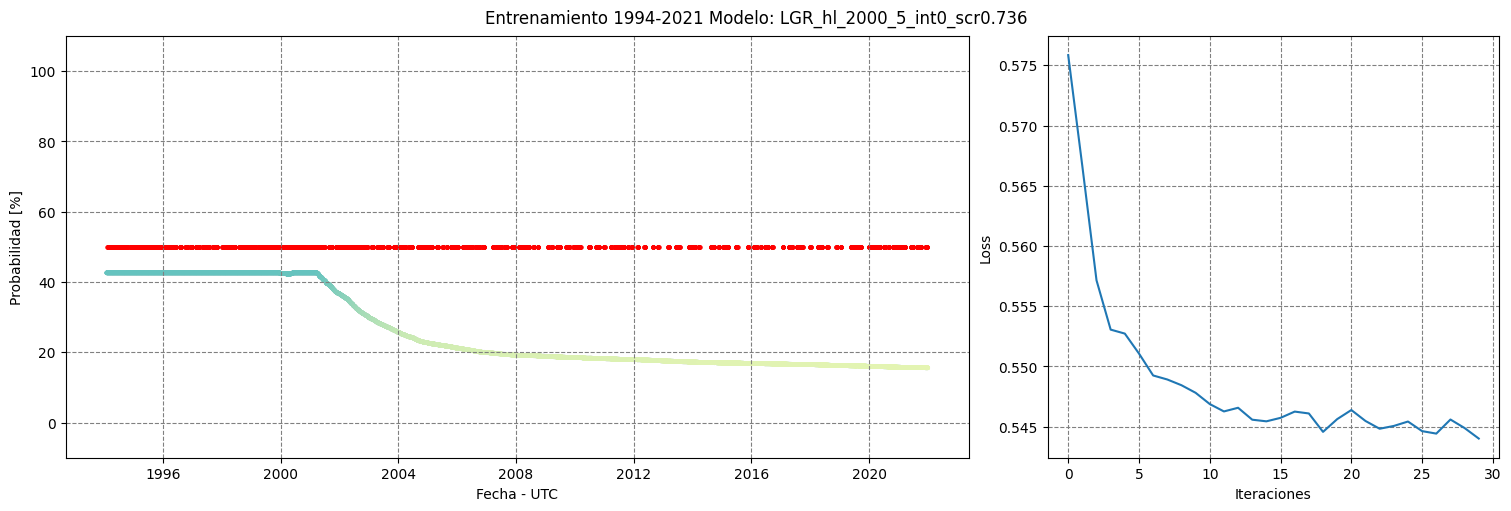

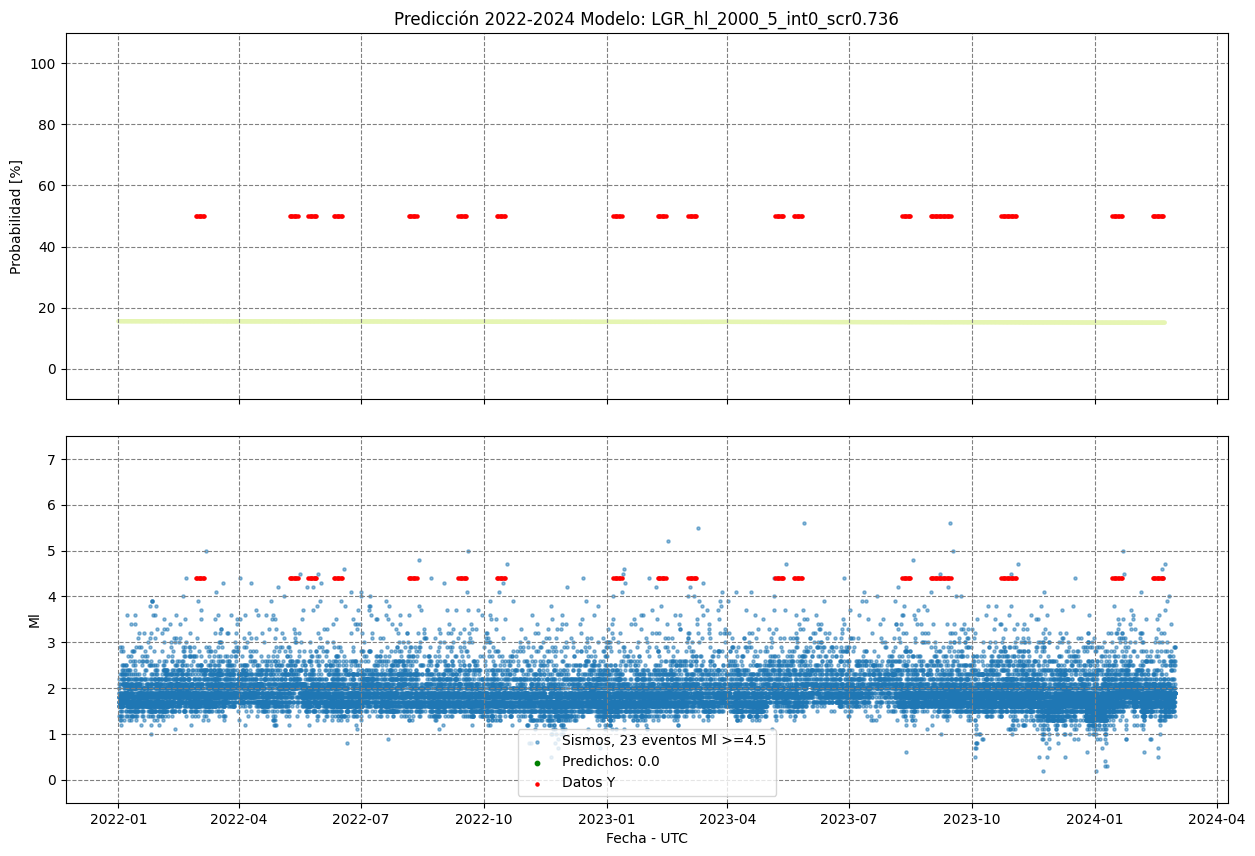

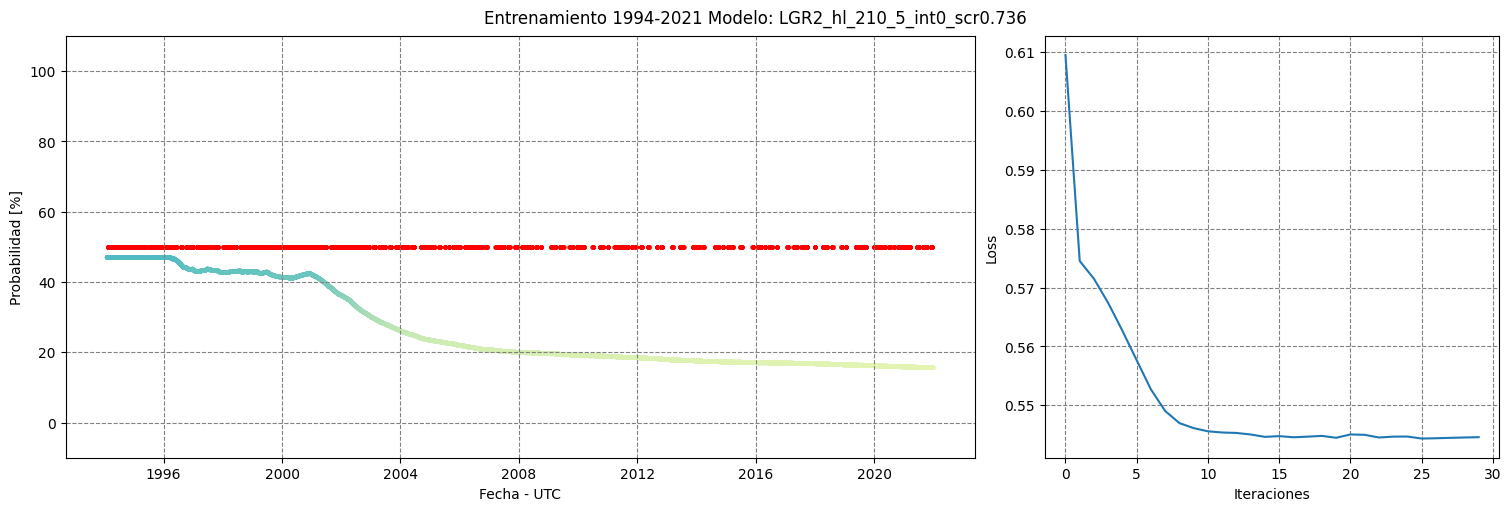

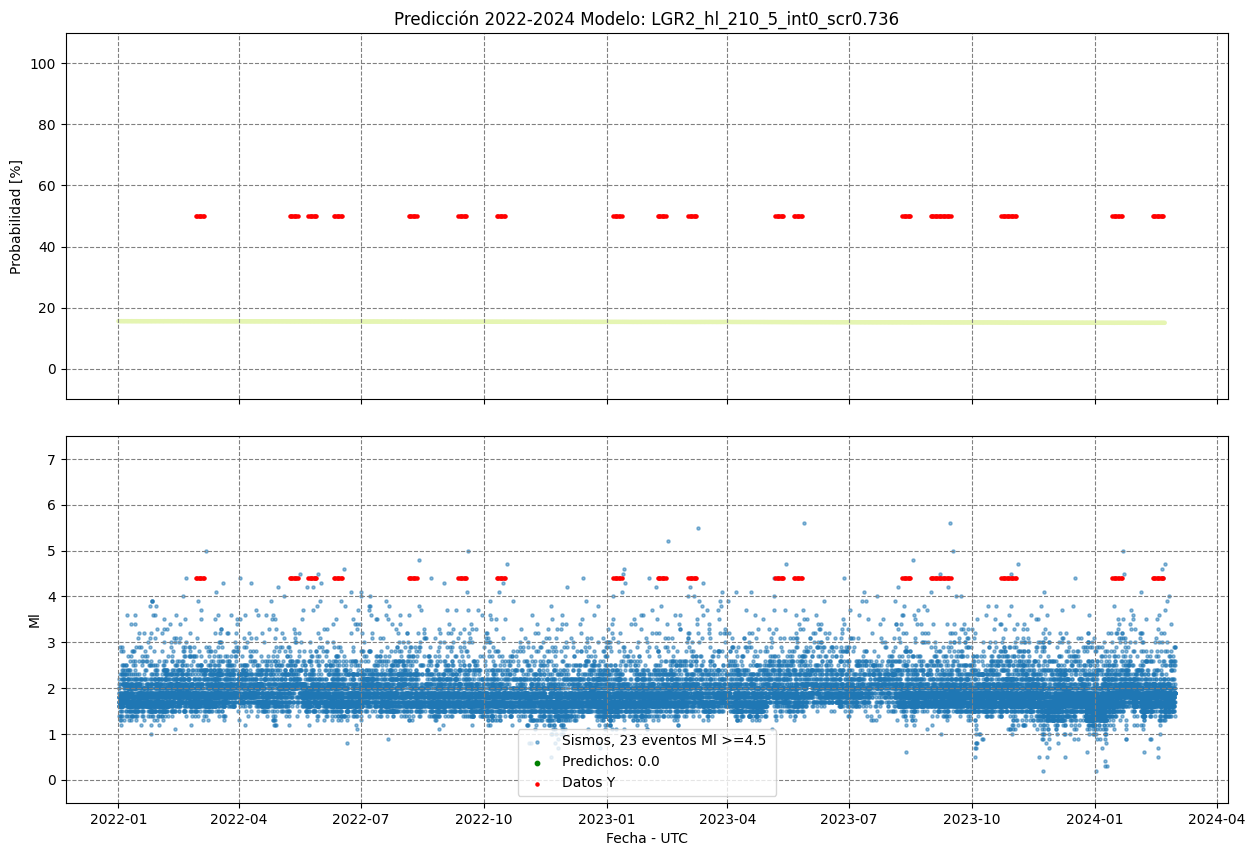

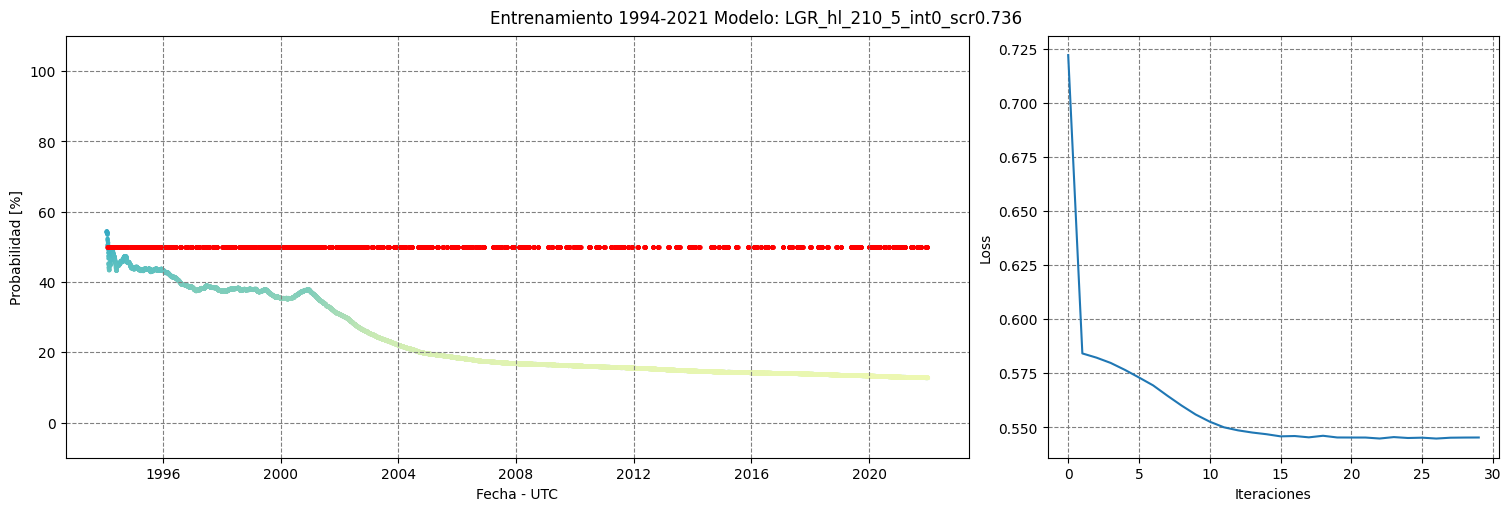

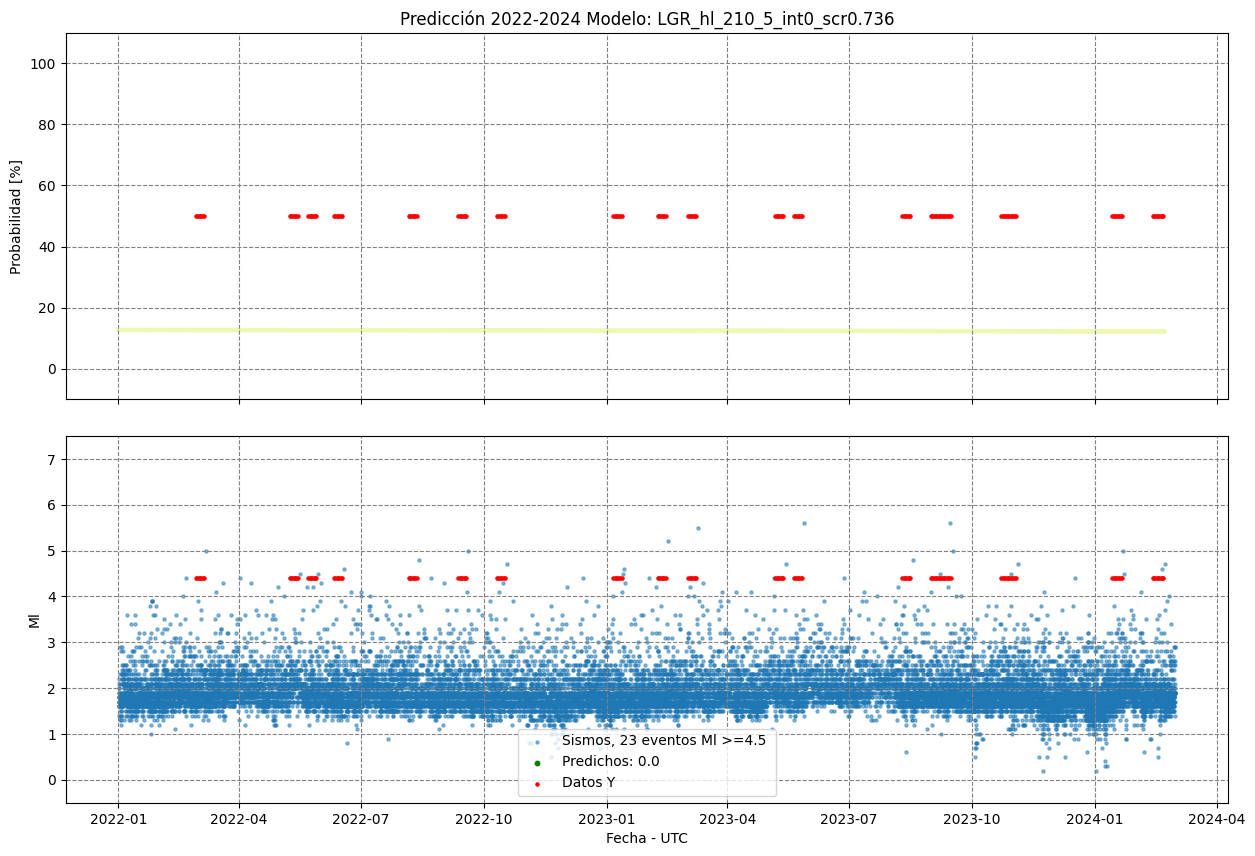

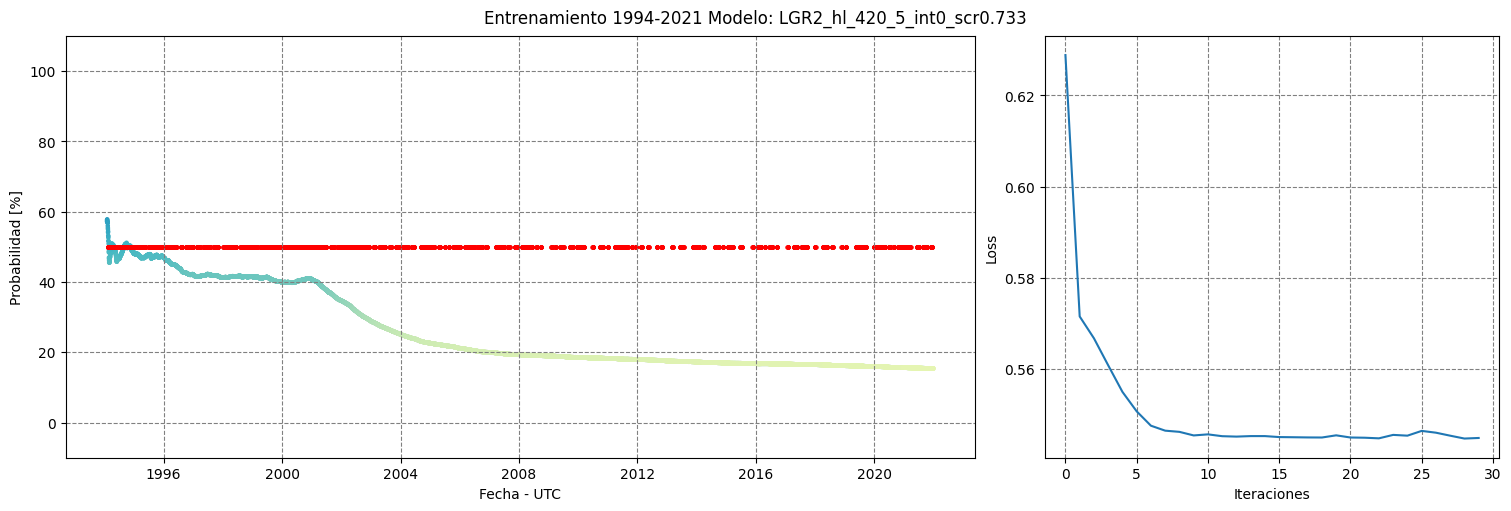

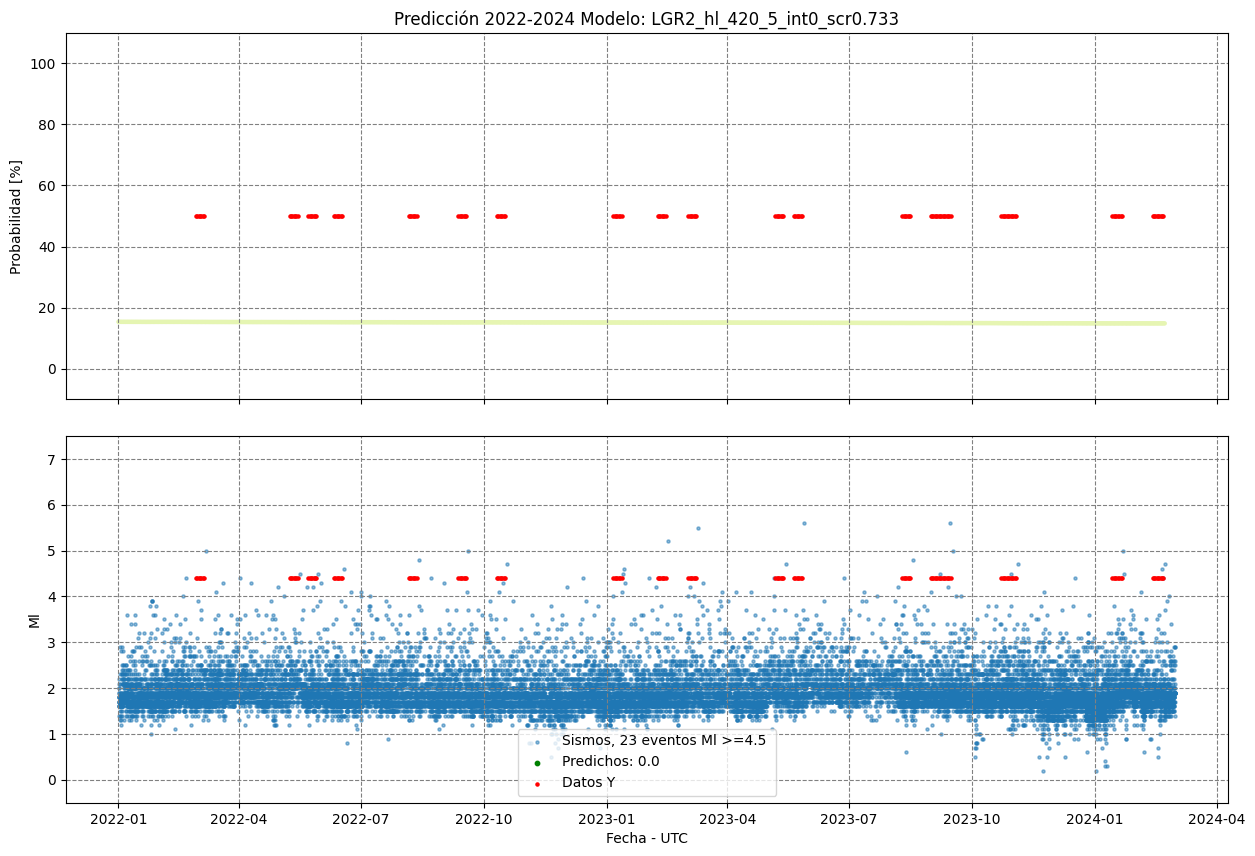

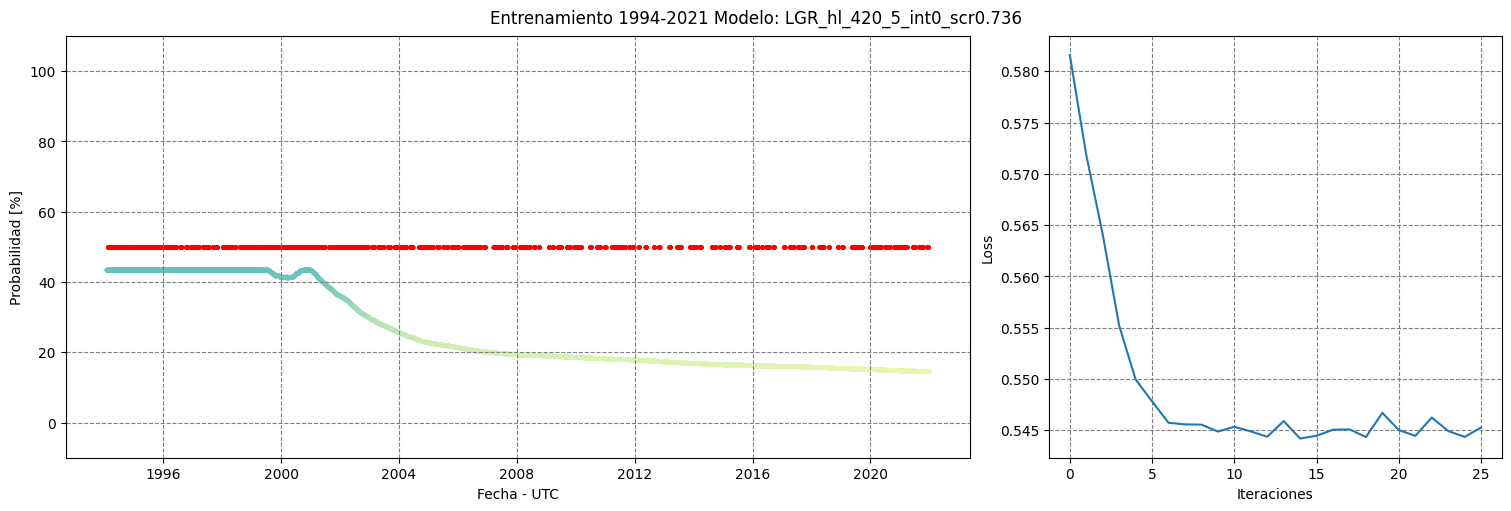

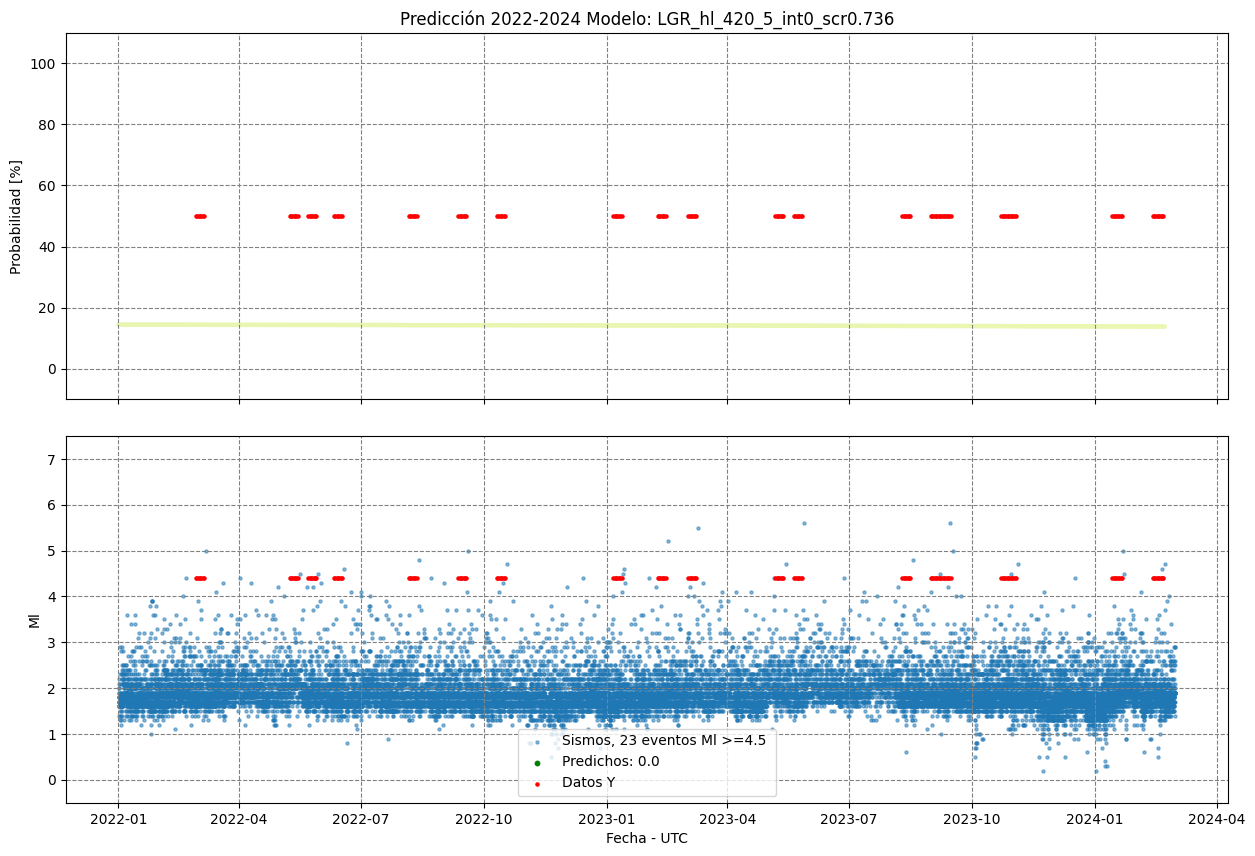

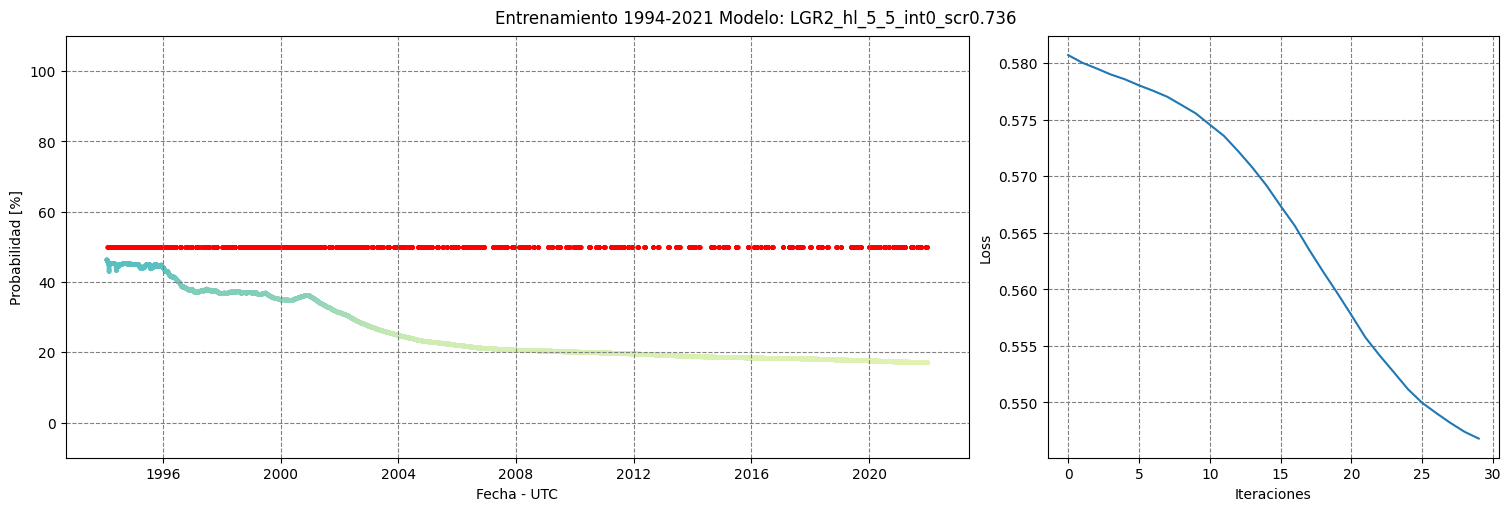

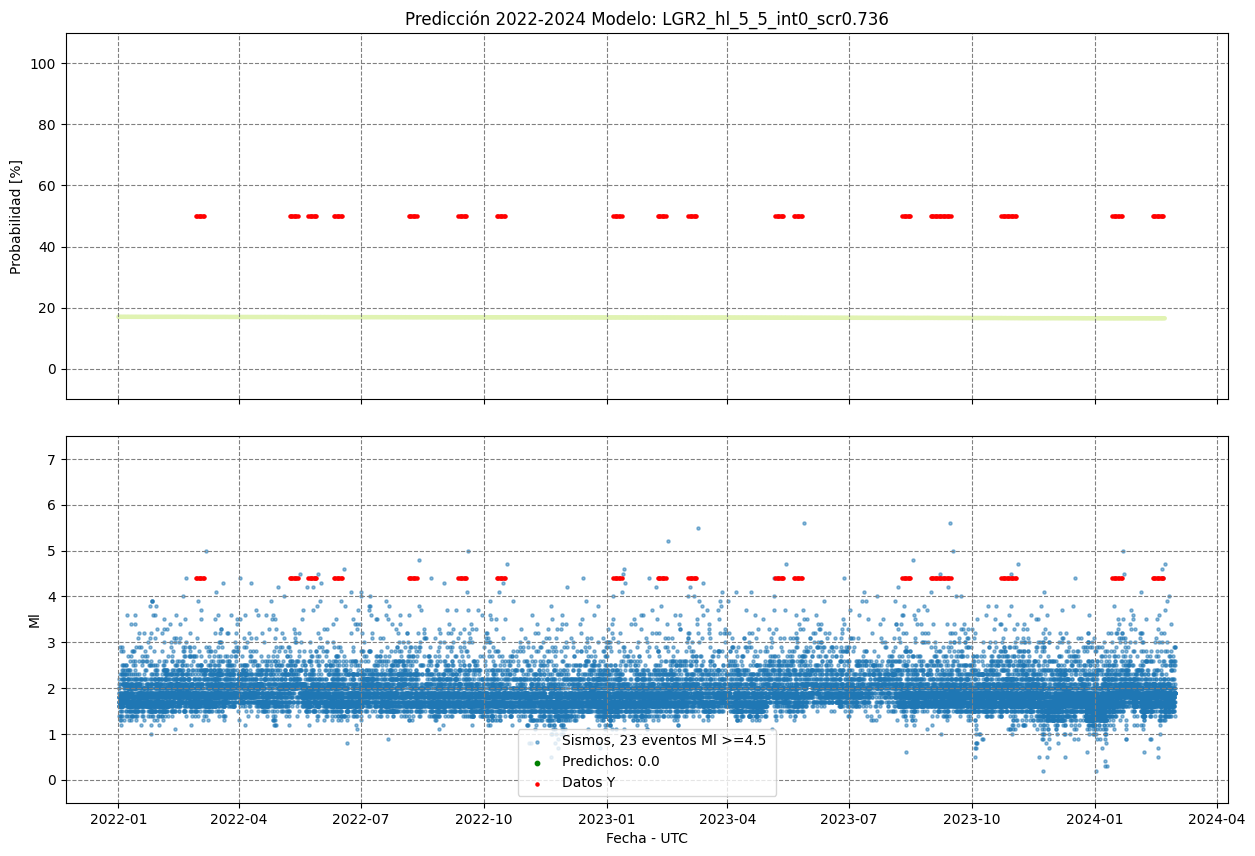

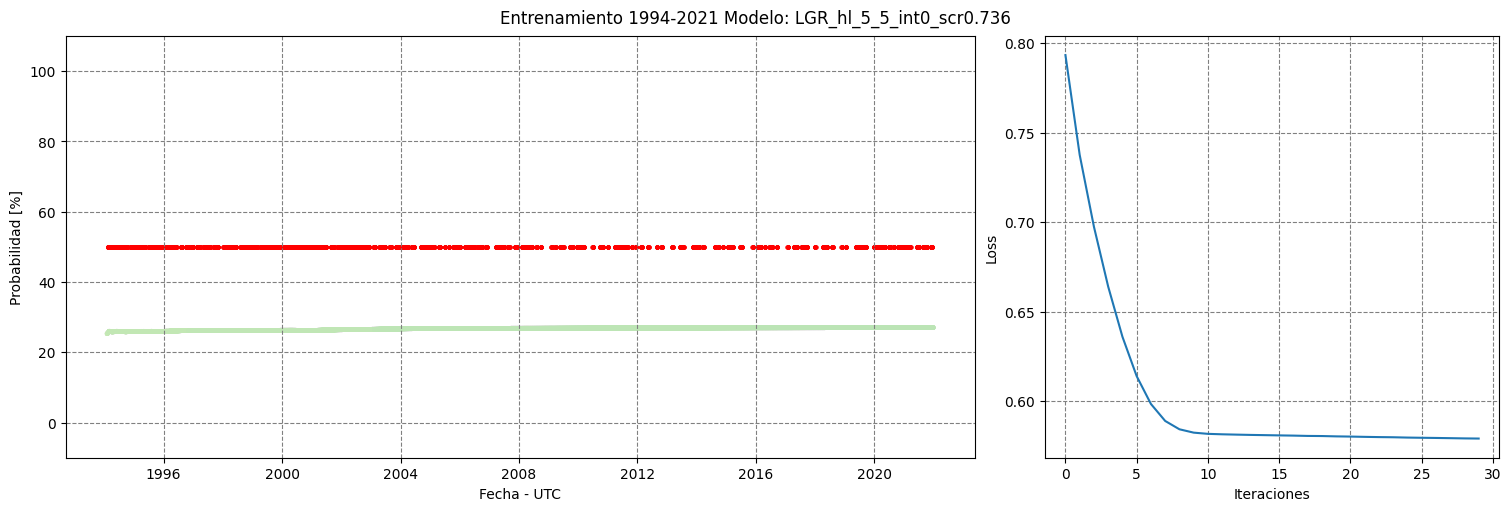

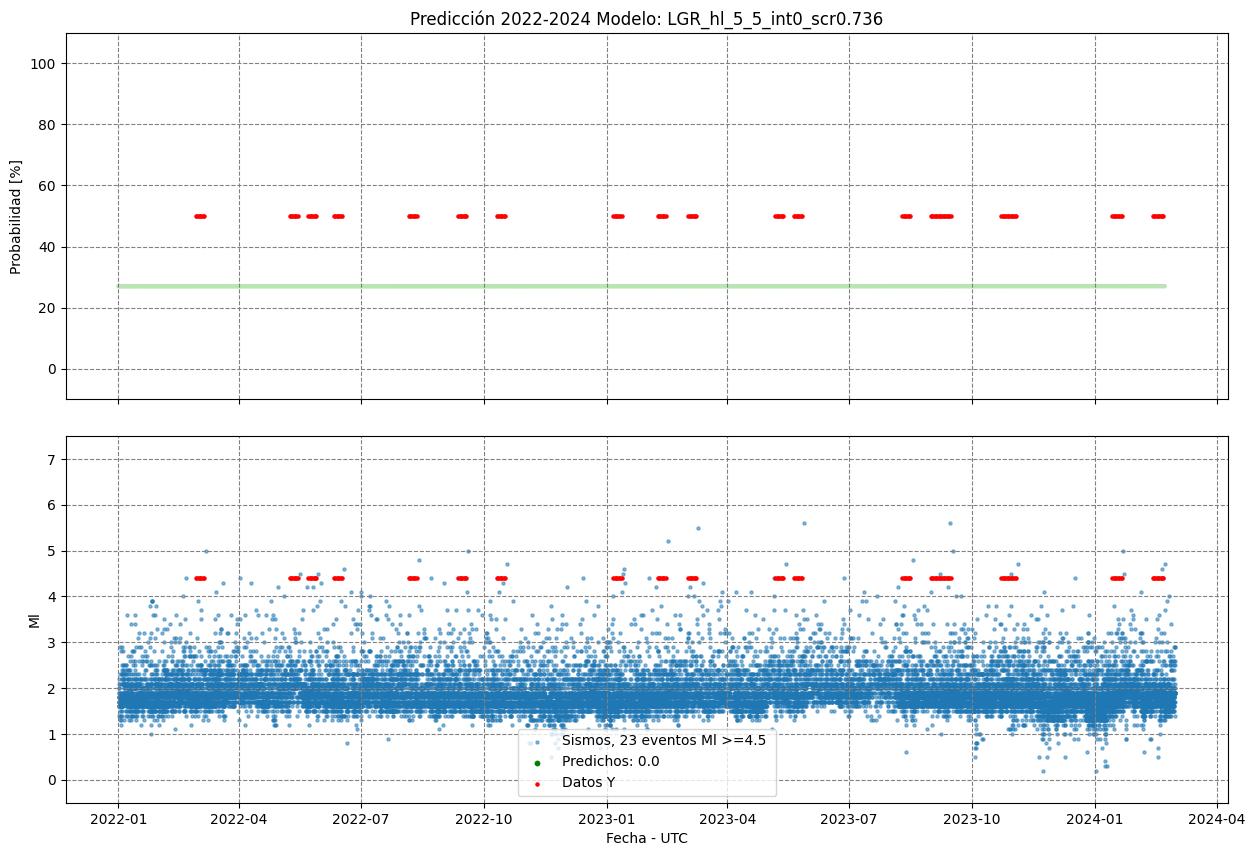

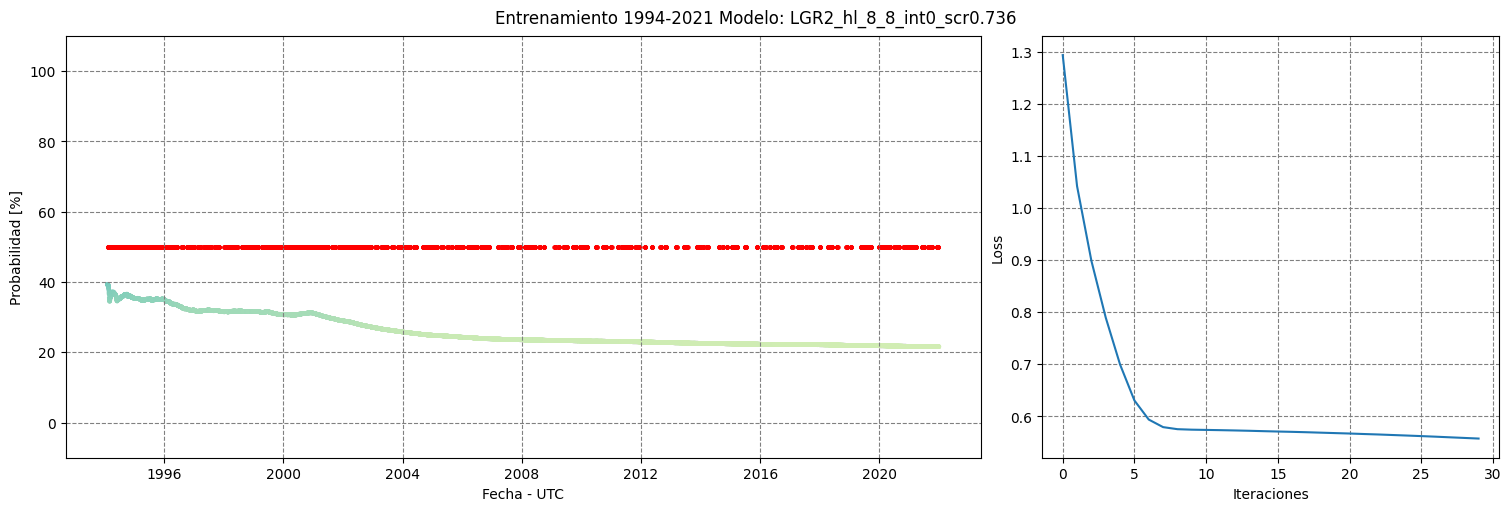

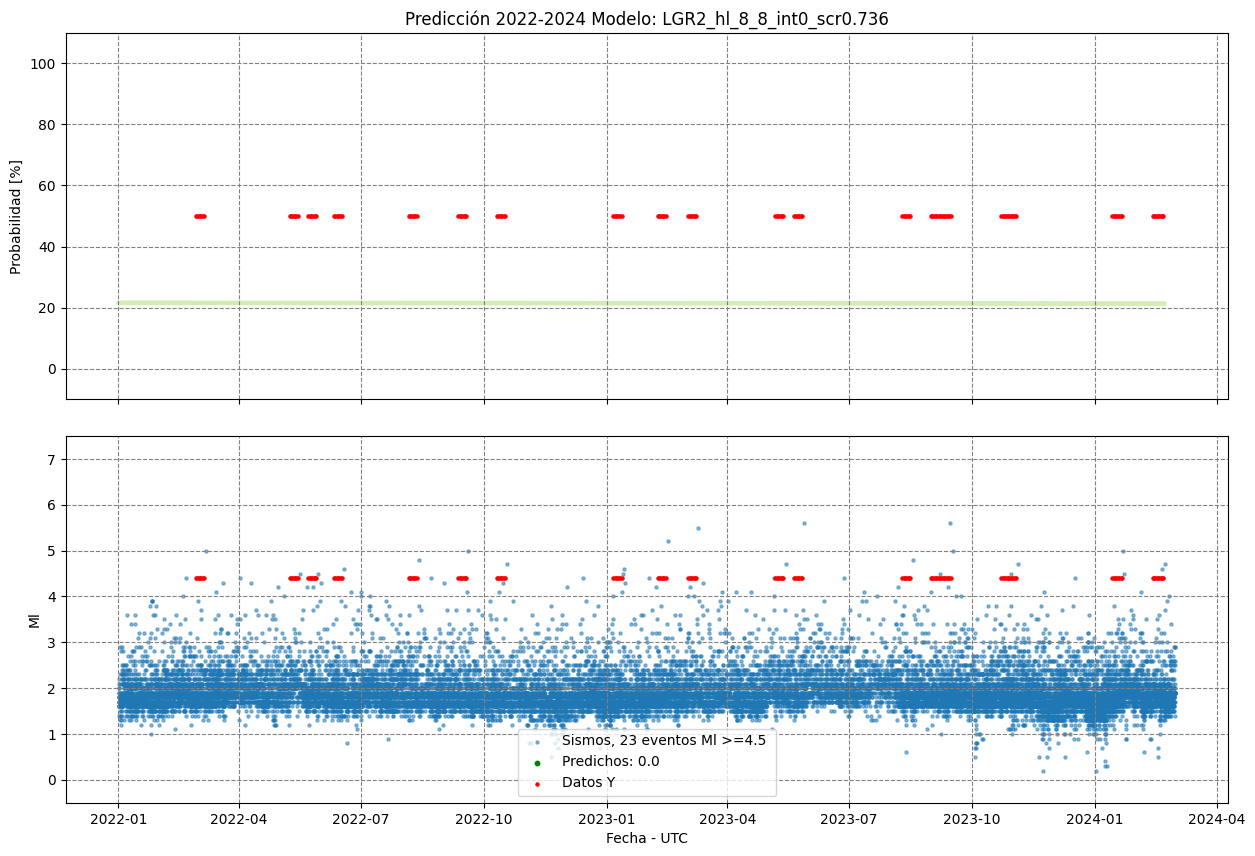

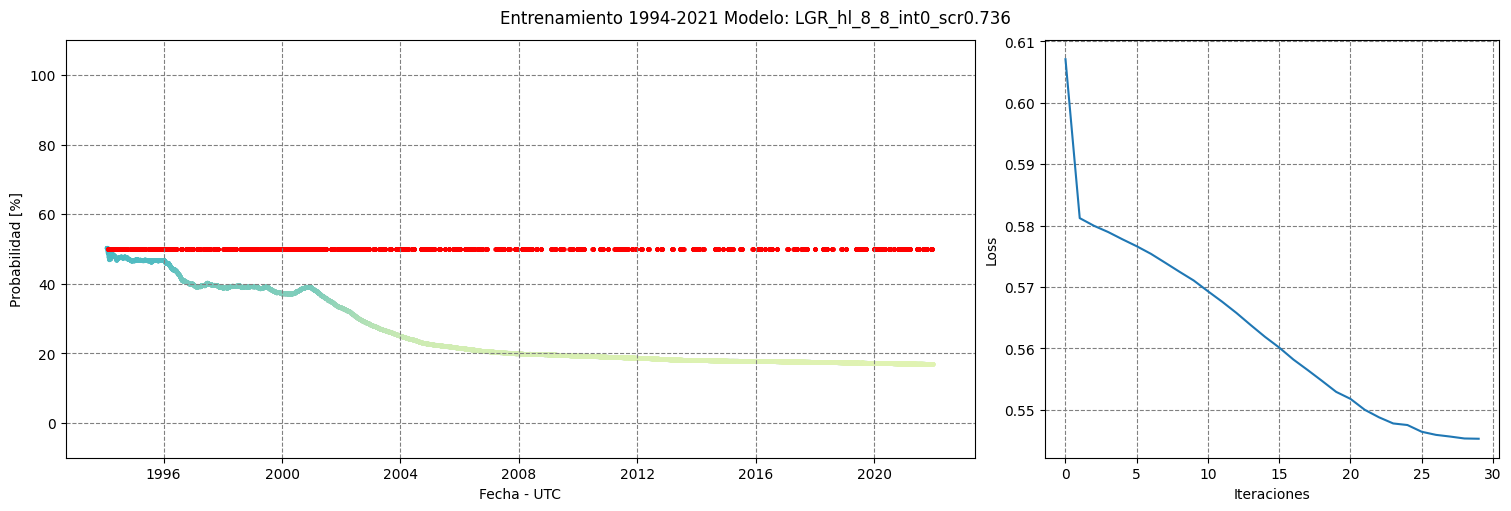

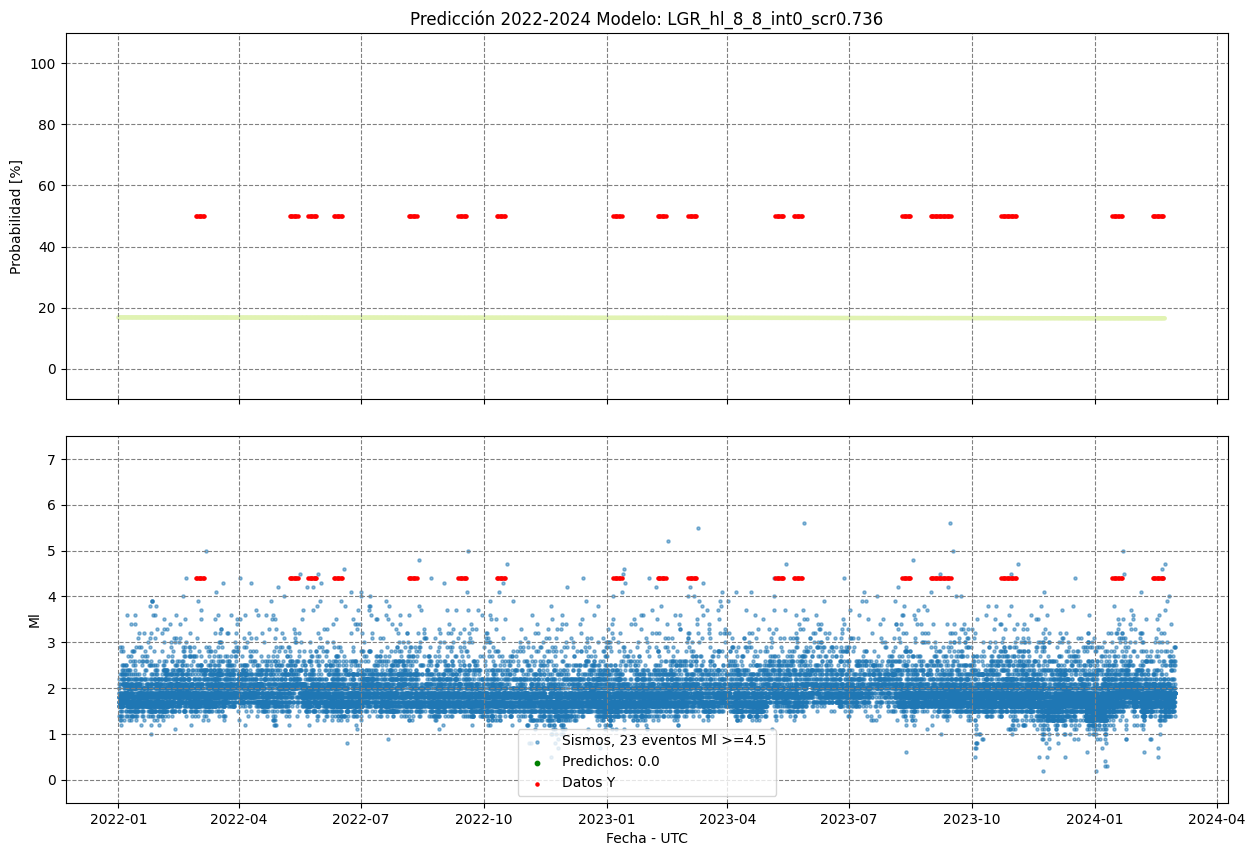

In [ ]:
for modelo in listaModelos:
  if 'joblib' in modelo:
    if 'LGR_' in modelo:
      X2023 = np.loadtxt(pathDatos+'Todos_LGR__X2022.txt')
      y2023 = np.loadtxt(pathDatos+'Todos_LGR__y2022.txt')
      X2022 = np.loadtxt(pathDatos+'Todos_LGR__X2021.txt')
      y2022 = np.loadtxt(pathDatos+'Todos_LGR__y2021.txt')
    if 'LGR2_' in modelo:
      X2023 = np.loadtxt(pathDatos+'Todos_LGR2__X2022.txt')
      y2023 = np.loadtxt(pathDatos+'Todos_LGR2__y2022.txt')
      X2022 = np.loadtxt(pathDatos+'Todos_LGR2__X2021.txt')
      y2022 = np.loadtxt(pathDatos+'Todos_LGR2__y2021.txt')

    modelo_P = load(pathModelos+modelo)
    # 2023
    predichosModelo = modelo_P.predict(X2023)
    predProb_Modelo = modelo_P.predict_proba(X2023)[:,1]
    # 1994-2023
    #predichosModelo_2022 = modelo_P.predict(X2022)
    predProb_Modelo_2022 = modelo_P.predict_proba(X2022)[:,1]

    filtro2022 = (df_Dias['Fecha'].dt.year < 2022).to_numpy()
    filtro2023 = (df_Dias['Fecha'].dt.year >= 2022).to_numpy()

    # Figura entrenamiento 1994-2021
    fig = plt.figure(figsize=(15,5), constrained_layout=True)
    gs = fig.add_gridspec(1,3)

    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2])

    ax1.scatter(df_Dias['Fecha'][filtro2022],
                predProb_Modelo_2022*100,
                s= 5,
                c=predProb_Modelo_2022*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax1.scatter(df_Dias['Fecha'][filtro2022][y2022 >= 1],
                y2022[y2022 >= 1] * 50,
                s= 5,
                c='r')
    ax1.set_ylim(-10, 110)
    ax1.set_ylabel('Probabilidad [%]')
    ax1.set_xlabel('Fecha - UTC')
    ax1.grid(ls='--', color='grey')

    ax2.plot(np.arange(len(modelo_P.loss_curve_)),
            modelo_P.loss_curve_)
    ax2.grid(ls='--', color='grey')
    ax2.set_xlabel('Iteraciones')
    ax2.set_ylabel('Loss')

    plt.suptitle(f'Entrenamiento 1994-2021 Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'1994_2021_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


    # Figuras 2023
    fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
    fig.subplots_adjust(hspace=0.1)

    # Probabilidad
    ax[0].scatter(df_Dias['Fecha'][filtro2023],
                predProb_Modelo*100,
                s= 5,
                c=predProb_Modelo*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax[0].scatter(df_Dias['Fecha'][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 50,
                s= 5,
                c='r')

    ax[0].set_ylim(-10, 110)
    ax[0].set_ylabel('Probabilidad [%]')
    #ax[0].set_xlabel('Fecha - UTC')
    ax[0].grid(ls='--', color='grey')
    ax[0].set_title(f'Predicción 2022-2024 Modelo: {modelo[:-7]}')

    # Eventos logrados
    event4_5 = df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()]
    event4_5 = event4_5 >= 4.5
    event4_5 = sum(event4_5)
    ax[1].scatter(df['Date-Time'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                s=5,
                label=f'Sismos, {event4_5} eventos Ml >=4.5 ',
                alpha=0.5)

    ax[1].scatter(df_Dias['Fecha'][filtro2023][predichosModelo >= 1],
                predichosModelo[predichosModelo >= 1]*7,
                s= 10,
                c='g',
                label=f'Predichos: {sum(predichosModelo)}')


    ax[1].scatter(df_Dias['Fecha'][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 4.4,
                s= 5,
                c='r',
                label='Datos Y')

    ax[1].set_ylim(-0.5, 7.5)
    ax[1].set_ylabel('Ml')
    ax[1].set_xlabel('Fecha - UTC')
    ax[1].grid(ls='--', color='grey')


    plt.legend(loc=8)

    plt.savefig((pathSaveFiguras + f'2022_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()

    print('\n')

# End